# REACHING_TASK --> Use this kernal

In [200]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os,sys,glob, json
import _pickle as pkl
import dlab
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Make sure you use version 2.2.0 of pynwb
- pip uninstall pynwb
- pip install pynwb==2.2.0

In [201]:
import pynwb
print(pynwb.__version__)

2.3.3


# Paths needed to be changed to your own paths

In [202]:
file_name = 'reach7_07_2024-12-04_20-57-49_008'
root_recording_folder = fr"G:\Grant\neuropixels\kilosort_recordings\{file_name}"

In [203]:

recording_folder = root_recording_folder + r"\Record Node 103\experiment1\recording1\continuous"
if not os.path.exists(recording_folder):
    raise FileNotFoundError(f"Recording folder not found: {recording_folder}")
else:
    print("Recording folder found: ", recording_folder)

Recording folder found:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous


##### Find the behavior files from the recording folder
- if threy are not found, you will need to manually specify the behavior file paths

In [204]:
root_behavior_path = r'Z:\PHYS\ChristieLab\Lab Management\Grant\reaching_data\compressed_data\Reach7\20241204\christielab\session006'
date = '20241204'
session_num = 'session006'

In [302]:
frontCam_events_txt = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_events.txt'
frontCam_timestamps = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_frontCam_timestamps.txt'
stim_frame_path = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_sideCam_timestamps.txt'

if not os.path.exists(frontCam_events_txt):
    raise FileNotFoundError("FrontCam events txt file not found")
if not os.path.exists(frontCam_timestamps):
    raise FileNotFoundError("FrontCam timestamps txt file not found")
if not os.path.exists(stim_frame_path):
    raise FileNotFoundError("Stimulus frame txt file not found")
else:
    print("All Behavior files found")


All Behavior files found


#### Create a file name for the NWB file
- if an NWB already exists for this session, a new NWB file will be created with a timestamp added to the file name, so you dont over write the old file"

In [303]:
# THIS SHOULD NOT just point to the folder, but needs to include the name you want the nwb file to be called /nwb_file_name
nwb_save_path = fr"G:\Grant\neuropixels\nwb\{file_name}"

if not os.path.exists(nwb_save_path):
    print("Now NWB file found with this name, creating it now: ", nwb_save_path)
else:
    print("NWB save file already exists, saving you from overwriting your data by adding a timestamp to the end of the file name")
    nwb_save_path = nwb_save_path +'___' + dt.datetime.now().strftime("_%Y-%m-%d_%H-%M-%S")


NWB save file already exists, saving you from overwriting your data by adding a timestamp to the end of the file name


#### Create directories for reach event data to save to

In [304]:
reach_event_save_path = root_recording_folder+ '\\all_reach_events'
full_reach_event_save_path = root_recording_folder+ '\\full_reach_events'

# Careful as this will plot all the reaches in the recording, if you have a long recording this will take a long time
if not os.path.exists(reach_event_save_path):
    os.makedirs(reach_event_save_path)
    print('Directory created: , ', reach_event_save_path)
else:
    print('Directory already exists: ', reach_event_save_path)

if not os.path.exists(full_reach_event_save_path):
    os.makedirs(full_reach_event_save_path)
    print('Directory created: ', full_reach_event_save_path)
else:
    print('Directory already exists: ', full_reach_event_save_path)

Directory already exists:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\all_reach_events
Directory already exists:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\full_reach_events


In [208]:
#recording_folder = root_recording_folder
stim_path = frontCam_events_txt
frame_path = frontCam_timestamps
#nwb_path = save_path_nwb

### Load in raw recording data

In [209]:
recording_folder = root_recording_folder
# recording_folder = r'G:/Grant/rotation/2023-09-29_16-07-39_PaBont2'

experimenter = 'grh'
experiment_description= 'Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively'

# #spikeglx
# probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*-AP*'))]

probeids = ['A', 'B','C','D','E'] 

# Use MPM-relative probe depths (in microns)
probedepths = [4156,7013,1450,4878,6202] 

### Read in .txt files with event times logged as frame numbers

In [210]:
from collections import defaultdict
import time

# Initialize defaultdicts
data = defaultdict(list)

# Measure time for file processing
start_time = time.time()

# Open and read the file
with open(stim_path, 'r') as file:
    lines = file.readlines()

# Parse the data
for line in lines:
    parts = line.strip().split('\t')
    if len(parts) == 2:
        name, value = parts
        data[name].append(int(value))

print("File parsing completed in:", time.time() - start_time, "seconds")

# Access data directly
pellet_detected_frame = data['pellet_detected']
pellet_delivery_frame = data['pellet_delivery']
T5000_frame = data['T5000_played']
T6000_frame = data['T6000_played']

# Print summaries
print("Pellet Detected (First 5):", pellet_detected_frame[:5])
print("Total Detected Values:", len(pellet_detected_frame))
print("Pellet Delivery (First 5):", pellet_delivery_frame[:5])
print("Total Delivery Values:", len(pellet_delivery_frame))
print("T5000 Values (First 5):", T5000_frame[:5])
print("Total T5000 Values:", len(T5000_frame))
print("T6000 Values (First 5):", T6000_frame[:5])
print("Total T6000 Values:", len(T6000_frame))

# Divide each value by 150
pellet_detected_seconds = [v / 150 for v in pellet_detected_frame]
pellet_delivery_seconds = [v / 150 for v in pellet_delivery_frame]

print("\nPellet Detected (First 5 in Seconds):", pellet_detected_seconds[:5])
print("Pellet Delivery (First 5 in Seconds):", pellet_delivery_seconds[:5])

# Slow motion factor
slow_motion_factor = 4.994614744995619

pellet_delivery_slow_motion = [t * slow_motion_factor for t in pellet_delivery_seconds]
pellet_detected_slow_motion = [t * slow_motion_factor for t in pellet_detected_seconds]

print("\nPellet Detected Aligned to Slow Motion Video (First 5):", pellet_detected_slow_motion[:5])
print("Pellet Delivery Aligned to Slow Motion Video (First 5):", pellet_delivery_slow_motion[:5])

# Convert to minutes
detected_slowmo_minutes_array = [seconds / 60 for seconds in pellet_detected_slow_motion]
delivery_slowmo_minutes_array = [seconds / 60 for seconds in pellet_delivery_slow_motion]

print("\nPellet Detected (Slow Motion in Minutes - First 5):", detected_slowmo_minutes_array[:5])
print("Pellet Delivery (Slow Motion in Minutes - First 5):", delivery_slowmo_minutes_array[:5])


File parsing completed in: 0.07040810585021973 seconds
Pellet Detected (First 5): [2806, 4982, 7193, 9443, 11618]
Total Detected Values: 205
Pellet Delivery (First 5): [2731, 4906, 7118, 9369, 11544]
Total Delivery Values: 216
T5000 Values (First 5): [2733, 4908, 7120, 9372, 11546]
Total T5000 Values: 216
T6000 Values (First 5): [2608, 4819, 7032, 9282, 11457]
Total T6000 Values: 219

Pellet Detected (First 5 in Seconds): [18.706666666666667, 33.21333333333333, 47.95333333333333, 62.95333333333333, 77.45333333333333]
Pellet Delivery (First 5 in Seconds): [18.206666666666667, 32.70666666666666, 47.45333333333333, 62.46, 76.96]

Pellet Detected Aligned to Slow Motion Video (First 5): [93.4325931630514, 165.88780439712116, 239.5084257383566, 314.4276469132909, 386.84956071572736]
Pellet Delivery Aligned to Slow Motion Video (First 5): [90.93528579055358, 163.35719959299004, 237.01111836585878, 311.9636369724264, 384.38555077486285]

Pellet Detected (Slow Motion in Minutes - First 5): [1.5

##### verify the numbe of events 

In [211]:
print("total Detected Values:", len(pellet_detected_frame))
print("total Delivery Values:", len(pellet_delivery_frame))
print("total T5000 Values:", len(T5000_frame))
print("total T6000 Values:", len(T6000_frame))

total Detected Values: 205
total Delivery Values: 216
total T5000 Values: 216
total T6000 Values: 219


### load in .txt file containing each frame number. stored as time between frame in nano-seconds

In [212]:
import time

# Initialize variables
frames = []

# Measure time for file reading
start_time = time.time()

# Open and read the text file
with open(stim_frame_path, 'r') as file:
    frames = [int(line.strip()) for line in file]

print("File parsing completed in:", time.time() - start_time, "seconds")

# Summarize frames
print("Total Frames:", len(frames))
print("First 5 Frames:", frames[:5])

# Compute frame numbers and related time metrics
frame_numbers = [(index + 1) / 150 for index in range(len(frames))]
frames_txt_file = [index + 1 for index in range(len(frames))]

# Print results
print("\nFrame Numbers (First 5):", frame_numbers[:5])
print("Recording Time (Seconds):", len(frame_numbers) / 150)
print("Recording Time (Minutes):", len(frame_numbers) / 150 / 60)


File parsing completed in: 0.4918947219848633 seconds
Total Frames: 726963
First 5 Frames: [6667248, 6668080, 6667000, 6666704, 6667320]

Frame Numbers (First 5): [0.006666666666666667, 0.013333333333333334, 0.02, 0.02666666666666667, 0.03333333333333333]
Recording Time (Seconds): 4846.42
Recording Time (Minutes): 80.77366666666667


In [213]:
frame_path = frontCam_timestamps
# Initialize an empty list to store the numbers
frames = []

# Open and read the text file
with open(frame_path, 'r') as file:
    for line in file:
        number = int(line.strip())
        frames.append(number)

# Now, 'numbers' is a list containing all the numbers from the text file
print("Numbers Array:", frames[0:5])
print("total frames: ", len(frames))

# frame_numbers = [index + 1 for index in range(len(frames))]
frame_numbers = [(index + 1) / 150 for index in range(len(frames))]
frames_txt_file = [(index + 1) for index in range(len(frames))]



print('frame numbers: ', frame_numbers[0:5])
print('Recording Time Seconds:', len(frame_numbers)/150)
print('Recording Time Minutes:', len(frame_numbers)/150 / 60)





Numbers Array: [6667112, 6667592, 6666760, 6667920, 6666344]
total frames:  726965
frame numbers:  [0.006666666666666667, 0.013333333333333334, 0.02, 0.02666666666666667, 0.03333333333333333]
Recording Time Seconds: 4846.433333333333
Recording Time Minutes: 80.77388888888889


### Plot the time between each frame, to see drop frames
- each big blue spike is a droppe frame (womp womp)

total frame timestamps: 726965
recording duration seconds: 4846.433333333333
recording duration minutes: 80.77388888888889


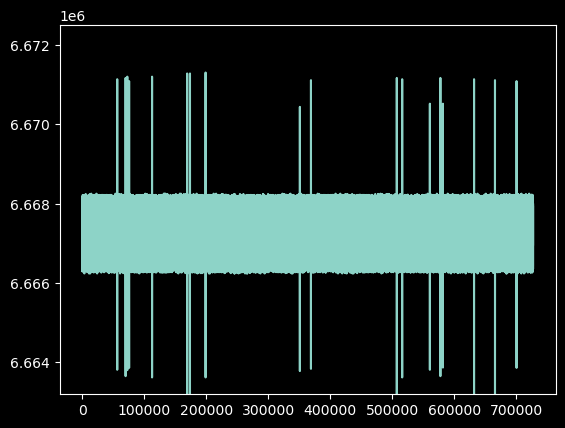

In [214]:
txt_file_frame_count = len(frames)
print("total frame timestamps:", txt_file_frame_count)
print("recording duration seconds:", txt_file_frame_count/150)
print("recording duration minutes:", txt_file_frame_count/150/60)
plt.ylim(6663200, 6672500)
plt.plot((frames))



### Load in the events data, logged in the digial lines of the openephys aquisition. and stored in the events folder of your recording
- if this cell fails, you can try the reaching_task kernal

In [215]:
from open_ephys.analysis import Session

directory = recording_folder # for example
directory = root_recording_folder # for example


session = Session(directory)
print(f'session: {session}')


session: 
Open Ephys Recording Session Object
Directory: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008

<object>.recordnodes:
  Index 0: Record Node 103 (binary format)



In [216]:
session.recordnodes[0].recordings[0].events
session.recordnodes[0].recordings[0].events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
0,1,610364,244.002726,100,3,ProbeB-LFP,0
1,1,610369,244.002729,100,1,ProbeA-LFP,0
2,1,7324428,244.002733,100,0,ProbeA-AP,0
3,1,610362,244.002735,100,6,ProbeD-LFP,0
4,1,7324369,244.002736,100,2,ProbeB-AP,0
...,...,...,...,...,...,...,...
833192,1,13294262,5317.560000,100,1,ProbeA-LFP,1
833193,1,13294028,5317.560039,100,8,ProbeE-LFP,1
833194,1,159528341,5317.560075,100,7,ProbeE-AP,1
833195,1,159529481,5317.560237,100,5,ProbeD-AP,1


In [217]:
events_df = pd.DataFrame(session.recordnodes[0].recordings[0].events)


# Speical global_timestamps df 
- this is used ONLY if your timestamps get messed up due to a syncronization issue during the recording, otherwise do not run the cell bellow
#### Here are the steps to make a global_timestamps df if our data is messed up
- use the manually_align_timestamps.ipynb file 

In [218]:
# global_timestamps_df = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\events\global_timestamps\global_timestamps_overwrite.csv"
# events_df = pd.read_csv(global_timestamps_df)
# events_df

### Verify all event types are being recorded

In [219]:
probeA_AP = events_df[events_df.stream_name == 'ProbeA-AP' ]
probeA_AP

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
2,1,7324428,244.002733,100,0,ProbeA-AP,0
13,1,7339428,244.502733,100,0,ProbeA-AP,1
28,1,7354429,245.002767,100,0,ProbeA-AP,0
34,1,7369429,245.502767,100,0,ProbeA-AP,1
45,1,7384429,246.002767,100,0,ProbeA-AP,0
...,...,...,...,...,...,...,...
833147,1,159471146,5315.559654,100,0,ProbeA-AP,1
833165,1,159486147,5316.060033,100,0,ProbeA-AP,0
833167,1,159501147,5316.559687,100,0,ProbeA-AP,1
833184,1,159516147,5317.060033,100,0,ProbeA-AP,0


In [220]:
probeA_AP = events_df[events_df.stream_name == 'ProbeA-AP' ]
probeB_AP = events_df[events_df.stream_name == 'ProbeB-AP' ]
probeC_AP = events_df[events_df.stream_name == 'ProbeC' ]
probeD_AP = events_df[events_df.stream_name == 'ProbeD-AP' ]
probeE_AP = events_df[events_df.stream_name == 'ProbeE-AP' ]


In [221]:
ni_df = events_df[events_df.stream_name == 'PXIe-6341' ]
ni_df

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
12,7,9796405,244.502731,102,9,PXIe-6341,1
27,7,9816405,245.002746,102,9,PXIe-6341,0
38,7,9836405,245.502785,102,9,PXIe-6341,1
39,7,9856404,246.002751,102,9,PXIe-6341,0
52,7,9876404,246.502766,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833151,7,212632632,5315.559944,102,9,PXIe-6341,1
833160,7,212652631,5316.059934,102,9,PXIe-6341,0
833171,7,212672631,5316.559949,102,9,PXIe-6341,1
833180,7,212692630,5317.059939,102,9,PXIe-6341,0


### SideCam Frame numbers are recorded in the events folder on digital line 8, and the rest of the digial lines are made into veraibles below 
- Digital Line 8

In [222]:
frame_events = ni_df[ni_df['line'] == 8]
frame_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
79,8,9923577,247.682126,102,9,PXIe-6341,1
80,8,9923843,247.688777,102,9,PXIe-6341,0
81,8,9924111,247.695477,102,9,PXIe-6341,1
82,8,9924376,247.702102,102,9,PXIe-6341,0
83,8,9924644,247.708802,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
826382,8,203826252,5095.393865,102,9,PXIe-6341,0
826383,8,203826520,5095.400565,102,9,PXIe-6341,1
826384,8,203826786,5095.407215,102,9,PXIe-6341,0
826385,8,203827054,5095.413915,102,9,PXIe-6341,1


### Sync pulse is recorded on digital line 7, every half second
- Digital line 7

In [223]:
sync_pulse_events = ni_df[ni_df['line'] == 7]
sync_pulse_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
12,7,9796405,244.502731,102,9,PXIe-6341,1
27,7,9816405,245.002746,102,9,PXIe-6341,0
38,7,9836405,245.502785,102,9,PXIe-6341,1
39,7,9856404,246.002751,102,9,PXIe-6341,0
52,7,9876404,246.502766,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833151,7,212632632,5315.559944,102,9,PXIe-6341,1
833160,7,212652631,5316.059934,102,9,PXIe-6341,0
833171,7,212672631,5316.559949,102,9,PXIe-6341,1
833180,7,212692630,5317.059939,102,9,PXIe-6341,0


### TTL created when paw passes through stimulus ROI and the mean luminance is above threshold
- Digital line 6

In [224]:
stimROI_events = ni_df[ni_df['line'] == 6]
stimROI_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
84,6,9924705,247.710327,102,9,PXIe-6341,1
85,6,9924905,247.715327,102,9,PXIe-6341,0
3275,6,10675426,266.478939,102,9,PXIe-6341,1
3276,6,10675627,266.483964,102,9,PXIe-6341,0
5700,6,11243198,280.673692,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813626,6,200828436,5020.446225,102,9,PXIe-6341,0
818476,6,201968310,5048.943927,102,9,PXIe-6341,1
818477,6,201968510,5048.948927,102,9,PXIe-6341,0
820994,6,202558230,5063.692367,102,9,PXIe-6341,1


### TTL for tone1 (T5000) 
- Digital line 5

In [225]:
tone1_events = ni_df[ni_df['line'] == 5]
tone1_events.head()
tone1_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
3038,5,10618561,265.057246,102,9,PXIe-6341,1
3039,5,10618759,265.062196,102,9,PXIe-6341,0
5545,5,11208394,279.803539,102,9,PXIe-6341,1
5547,5,11208591,279.808464,102,9,PXIe-6341,0
8064,5,11798546,294.557752,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813533,5,200806798,5019.905259,102,9,PXIe-6341,0
818383,5,201946826,5048.407304,102,9,PXIe-6341,1
818385,5,201947023,5048.412229,102,9,PXIe-6341,0
820853,5,202526538,5062.900044,102,9,PXIe-6341,1


### Each event is a single light pulse that goes out the optical fiber. these timestamps are the time the light pulse was sent out. it tells you nothing about the duration of each pulse
- Digital line 4

In [226]:
optical_events = ni_df[ni_df['line'] == 4]
optical_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
108486,4,35389461,884.348338,102,9,PXIe-6341,1
108488,4,35389661,884.353338,102,9,PXIe-6341,0
108491,4,35389861,884.358338,102,9,PXIe-6341,1
108493,4,35390061,884.363339,102,9,PXIe-6341,0
108495,4,35390261,884.368339,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833122,4,212586515,5314.406465,102,9,PXIe-6341,0
833123,4,212586915,5314.416466,102,9,PXIe-6341,1
833124,4,212587315,5314.426466,102,9,PXIe-6341,0
833125,4,212587715,5314.436466,102,9,PXIe-6341,1


### This is just Tone2 (T6000), (ie. when pellet was revealed)
- Digital line 3

In [227]:
tone2_events = ni_df[ni_df['line'] == 3]
tone2_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
3175,3,10652041,265.894271,102,9,PXIe-6341,1
3177,3,10652238,265.899196,102,9,PXIe-6341,0
5646,3,11232114,280.396529,102,9,PXIe-6341,1
5648,3,11232311,280.401454,102,9,PXIe-6341,0
8164,3,11822066,295.145770,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813637,3,200830597,5020.500252,102,9,PXIe-6341,0
818485,3,201970346,5048.994828,102,9,PXIe-6341,1
818487,3,201970543,5048.999753,102,9,PXIe-6341,0
821004,3,202560378,5063.746069,102,9,PXIe-6341,1


# Sort the global_timestamps dataframe by the 'global_timestamps' column
- required for some reason

In [228]:
frame_events = frame_events.sort_values(by="timestamp", ascending=True)
sync_pulse_events = sync_pulse_events.sort_values(by="timestamp", ascending=True)
tone1_events = tone1_events.sort_values(by="timestamp", ascending=True)
tone2_events = tone2_events.sort_values(by="timestamp", ascending=True)
stimROI_events = stimROI_events.sort_values(by="timestamp", ascending=True)
stimROI_frame_number = stimROI_events.sort_values(by="timestamp", ascending=True)
optical_events = optical_events.sort_values(by="timestamp", ascending=True)


In [229]:
probeA_AP = probeA_AP.sort_values(by="timestamp", ascending=True)
probeB_AP = probeB_AP.sort_values(by="timestamp", ascending=True)
probeC_AP = probeC_AP.sort_values(by="timestamp", ascending=True)
probeD_AP = probeD_AP.sort_values(by="timestamp", ascending=True)
probeE_AP = probeE_AP.sort_values(by="timestamp", ascending=True)

In [230]:
probeA_AP

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
2,1,7324428,244.002733,100,0,ProbeA-AP,0
13,1,7339428,244.502733,100,0,ProbeA-AP,1
28,1,7354429,245.002767,100,0,ProbeA-AP,0
34,1,7369429,245.502767,100,0,ProbeA-AP,1
45,1,7384429,246.002767,100,0,ProbeA-AP,0
...,...,...,...,...,...,...,...
833147,1,159471146,5315.559654,100,0,ProbeA-AP,1
833165,1,159486147,5316.060033,100,0,ProbeA-AP,0
833167,1,159501147,5316.559687,100,0,ProbeA-AP,1
833184,1,159516147,5317.060033,100,0,ProbeA-AP,0


### This cell is old and splits the data in half, but i now know the data is not split in half evenly. sometimes tone1 goes off and no tone2 goes off

In [231]:
# extract every 2nd value from the array and make it a new array, do the same for the other array
# tone1_events = tone1_2_events.iloc[::2, :]
# tone2_events = tone2_events.iloc[1::2, :]

#### extract the timestamps from the rows for each events dataframe  
- get array of the synchronized timestamps for all digital events

In [232]:
# frame_timestamps = frame_events['timestamp'].values
# print(f'goal: {60/150}')
# print(f'frames count {len(frame_timestamps)}')
# print(f'frame: {len(frame_timestamps)/150}')
# frame_timestamps[6] - frame_timestamps[1]

In [233]:
# Digital Line 8
frame_timestamps = frame_events['timestamp'].values

# Digital Line 7
sync_pulse_timestamps = sync_pulse_events['timestamp'].values
sync_pulse_timestamps = sync_pulse_timestamps[0::2]

# Digital Line 6
stimROI_timestamps  = stimROI_events['timestamp'].values
stimROI_timestamps = stimROI_timestamps[0::2]

# Digital Line 5
tone1_timestamps = tone1_events['timestamp'].values
tone1_timestamps = tone1_timestamps[0::2]

# Digital Line 4
optical_timestamps = optical_events['timestamp'].values

# Digital Line 4 --> (every 10th value)
first_optical_timestamp_per_event = optical_events['timestamp'].values
first_optical_timestamp_per_event = first_optical_timestamp_per_event[1::10]

# Digital Line 3 (NEED TO SET THIS UP FROM BUTTON)
tone2_timestamps  = tone2_events['timestamp'].values
tone2_timestamps = tone2_timestamps[0::2]


### Check that the timestamps are correct
- first part, check the total number of timestamps make sense
- Second part, check that the logic of the time stamps makes sense

In [234]:
print('Part 1: ')
print('frame timestamps:', len(frame_events))
print('sync_pulse timestamps:', len(sync_pulse_timestamps)) # 1hz
print('tone1 timestamps:', len(tone1_timestamps))
print('tone2 timestamps:', len(tone2_timestamps))
print('stimROI timestamps:', len(stimROI_timestamps))
print('optical timestamps:', len(optical_timestamps))
print('')
print('Part 2: ')
print('behavior video duration (min) using frames: ', round((len(frame_timestamps) / 150 / 60), 2))
print('open-ephys recording duration (min) using sync pulses: ', round((len(sync_pulse_timestamps) / 60), 2))
print('frame rate of camera (Value should be close to 150): ', round(len(frame_timestamps) / len(sync_pulse_timestamps), 2))
print('Avg time between frames (Goal is 0.40): ', round(np.mean(np.diff(frame_timestamps)) * 100, 2))
print('Avg time between sync pulses (Goal is 1.0): ', round(np.mean(np.diff(sync_pulse_timestamps)), 2))
print('Avg time between stimROI (should be roughly 15-20 seconds apart): ', round(np.mean(np.diff(stimROI_timestamps)), 2))
print('Avg time between first optical pulses (should be roughly identical to the value above for Avg time between stimROI): ', round(np.mean(np.diff(first_optical_timestamp_per_event)), 2))





Part 1: 
frame timestamps: 727088
sync_pulse timestamps: 5074
tone1 timestamps: 219
tone2 timestamps: 216
stimROI timestamps: 200
optical timestamps: 3360

Part 2: 
behavior video duration (min) using frames:  80.79
open-ephys recording duration (min) using sync pulses:  84.57
frame rate of camera (Value should be close to 150):  143.3
Avg time between frames (Goal is 0.40):  0.67
Avg time between sync pulses (Goal is 1.0):  1.0
Avg time between stimROI (should be roughly 15-20 seconds apart):  24.2
Avg time between first optical pulses (should be roughly identical to the value above for Avg time between stimROI):  13.22


#### Verify the duration of the recording, and the number of frames in the recording
- this should be the duration of the behavior video, not the full open-ephys recording duration. 
- because the open-ephys recording has baseline, opto-tagging, and other things making it longer

In [235]:
## Value should be 150, as the frame rate is 150 Hz, and the video was roughly 120 scoonds long
duration_of_video = 80 # in minutes

Behavior_video_length = duration_of_video * 60 # in seconds
print('value should be close to (150) because 150hz frame rate: ',len(frame_timestamps) / Behavior_video_length)

## Value is the duration of the behavior recording in minutes, because the frame rate is 150 Hz
print(len(frame_timestamps)/Behavior_video_length/60)


value should be close to (150) because 150hz frame rate:  151.47666666666666
2.524611111111111


#### Verify the time between the StimROI and the frame in which you saw light on the camera
- the Difference between Stim TTL & the first frame with an optical pusle seen should be less that 1.0ms

In [236]:
# light_seen_frame = [940,3985,6181,8418,11143,15432]
# stim_number = 0

# for i in light_seen_frame:

#     first_light_frame_vs_StimTTL_difference = (stimROI_timestamps[stim_number] -  frame_timestamps[i]) *100

#     print('stim number:', stim_number+1)
#     print(f'stimROI TTL timestamps Vs. timestamp of frame with first optical pulse: ', stimROI_timestamps[stim_number].round(2),frame_timestamps[i].round(2))
#     print(f'Difference between Stim TTL & the first frame with an optical pusle seen: ', first_light_frame_vs_StimTTL_difference.round(2))
#     print('')
    
#     stim_number += 1
    

#### Validate the time between tone2 and the optical times are small

### Plot tone1, tone2, stimROI, and optical timestamps

In [237]:
tone1_timestamps[0],tone2_timestamps[0], stimROI_timestamps[0], optical_timestamps[0]

(265.0572456559737, 265.8942706686352, 247.71032728126445, 884.3483381777169)

## Plot events to see if they are aligned

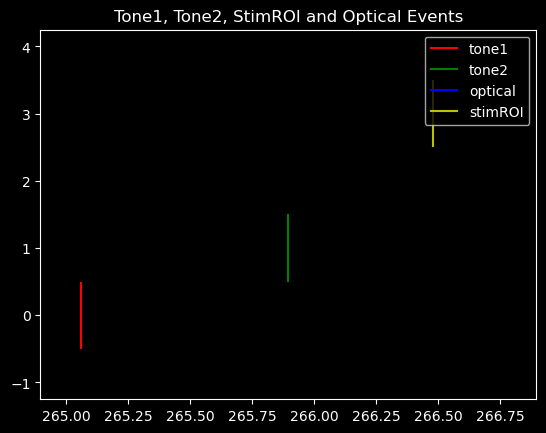

In [238]:
# Check one single event / reach
plt.eventplot([tone1_timestamps,tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r','g','b','y'])
plt.xlim(tone2_timestamps[0]-1, tone2_timestamps[0]+1)
plt.legend(['tone1','tone2', 'optical','stimROI'])
plt.title('Tone1, Tone2, StimROI and Optical Events')
plt.show()


### Plot zoomed in of the optical events to see if it was correct

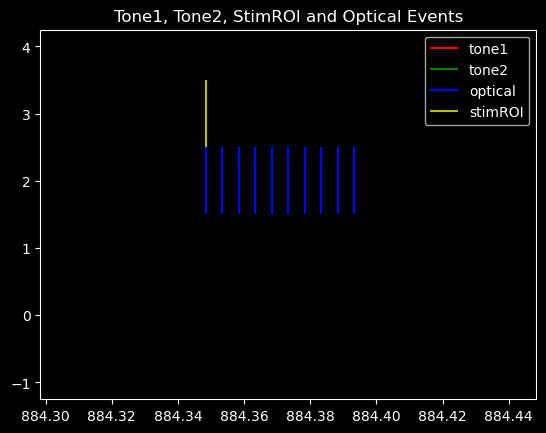

In [317]:
# Check one single event / reach
plt.eventplot([tone1_timestamps,tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r','g','b','y'])
plt.xlim(optical_timestamps[0]-0.05, optical_timestamps[0]+0.1)
plt.legend(['tone1','tone2', 'optical','stimROI'])
plt.title('Tone1, Tone2, StimROI and Optical Events')
plt.show()

## Look at a zoomed in version of the above plot above to see optical pulses more clearly

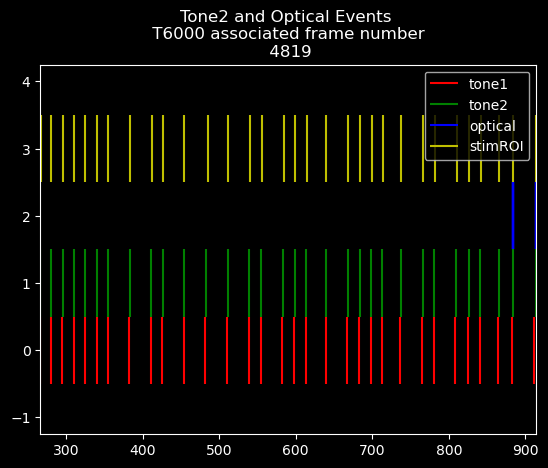

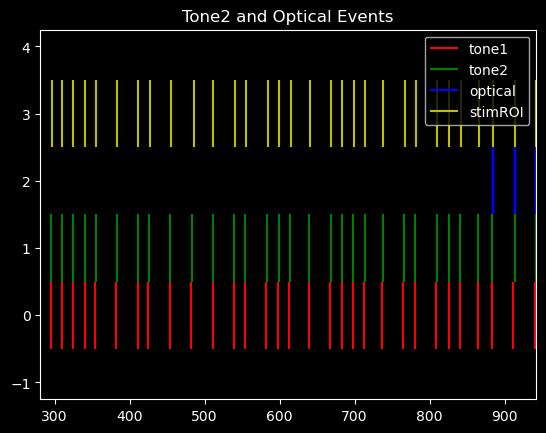

In [239]:
plt.eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
plt.xlim(stimROI_timestamps[1]-0.5, optical_timestamps[10]+0.5)
plt.legend(['tone1','tone2', 'optical','stimROI'])
plt.title(f'Tone2 and Optical Events \n T6000 associated frame number \n {T6000_frame[1]}')
plt.show()

plt.eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
plt.xlim(stimROI_timestamps[2]-0.02, optical_timestamps[20]+0.06)
plt.legend(['tone1','tone2', 'optical','stimROI'])
plt.title('Tone2 and Optical Events')
plt.show()

### find the frame number associated with the stimROI TTL pulse
- sometimes we get a tone2 without a stimROI, (likely the mouse did not reach)
- so this uses the time of both to align tone2 to its associated stimROI
- it does this by finding the difference between the stimROI TTL pulse and the tone2 TTL time (in seconds relative to neuropixel clock)  if they are within 10 seconds of eachother it groups them together. 

In [242]:
result = [(a,b) for a in tone1_timestamps for b in stimROI_timestamps if abs(b-a)<10]
results_w_indices = [(i, j, a, b) for i, a in enumerate(tone1_timestamps) for j, b, in enumerate(stimROI_timestamps) if abs(b-a)<10]
difference = [b-a for a,b in result]
difference_w_indices = [b-a for _,_,a,b in results_w_indices]
len(results_w_indices),results_w_indices[0:3], difference_w_indices[0:3]

(188,
 [(0, 1, 265.0572456559737, 266.47893916350813),
  (1, 2, 279.80353864124635, 280.67369213839635),
  (2, 3, 294.5577522140798, 295.9752234759382)],
 [1.4216935075344281, 0.8701534971499996, 1.4174712618583953])

In [311]:
len(optical_events) / 10

336.0

## Create a plot for every reach
- this saves the plots showing the timeing of the events as recorded by the digital board 
- plots are saved too the reach_event_save_path and full_reach_event_save_path (both paths are automatically created at the start of this 01_makeNWB.ipynb file, and should be in the root recording foler)

In [243]:
import pandas as pd
df = pd.DataFrame(T6000_frame)
# df.to_csv (T6000_frame_path, index = None, header=True)

Directory created:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\all_reach_events\2_combined_reach_events


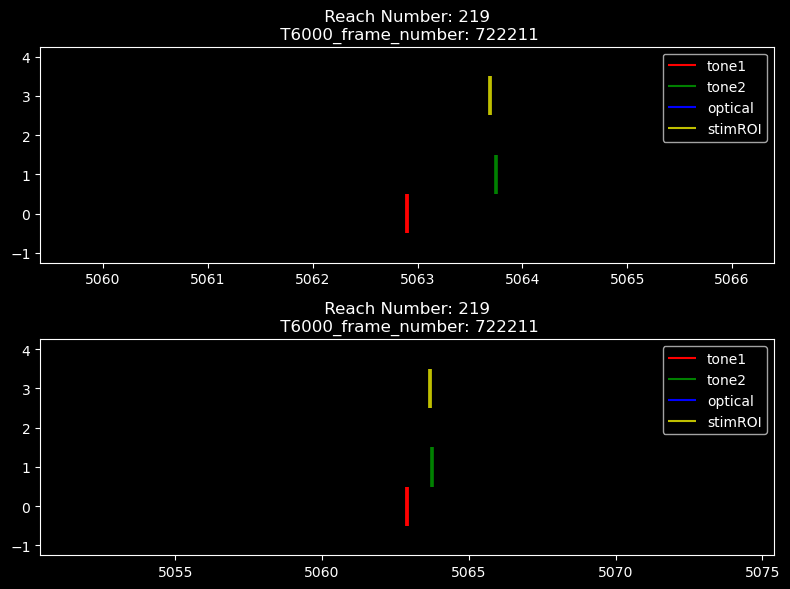

In [306]:
reach_event_save_path_02 = reach_event_save_path + '\\2_combined_reach_events'

if reach_event_save_path_02+f'\\reach_1.png' in glob.glob(reach_event_save_path_02+f'\\reach_*.png'):
    print('Files / plots already exist')
    print('either delete the plots or change the save path')
    
else:
    if not os.path.exists(reach_event_save_path_02):
        os.makedirs(reach_event_save_path_02)
        print('Directory created: ', reach_event_save_path_02)
        
    fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(8,6))

    for i in range(len(tone1_timestamps)):
        
        axs[0].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[0].set_xlim(tone1_timestamps[i]-3.5, tone1_timestamps[i]+3.5)
        axs[0].legend(['tone1','tone2', 'optical','stimROI'])
        axs[0].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[1].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[1].set_xlim(tone1_timestamps[i]-12.5, tone1_timestamps[i]+12.5)
        axs[1].legend(['tone1','tone2', 'optical','stimROI'])
        axs[1].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        plt.tight_layout()

        plt.savefig(reach_event_save_path_02+f'\\reach_{i}.png')

Directory created:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\all_reach_events\3_combined_reach_events


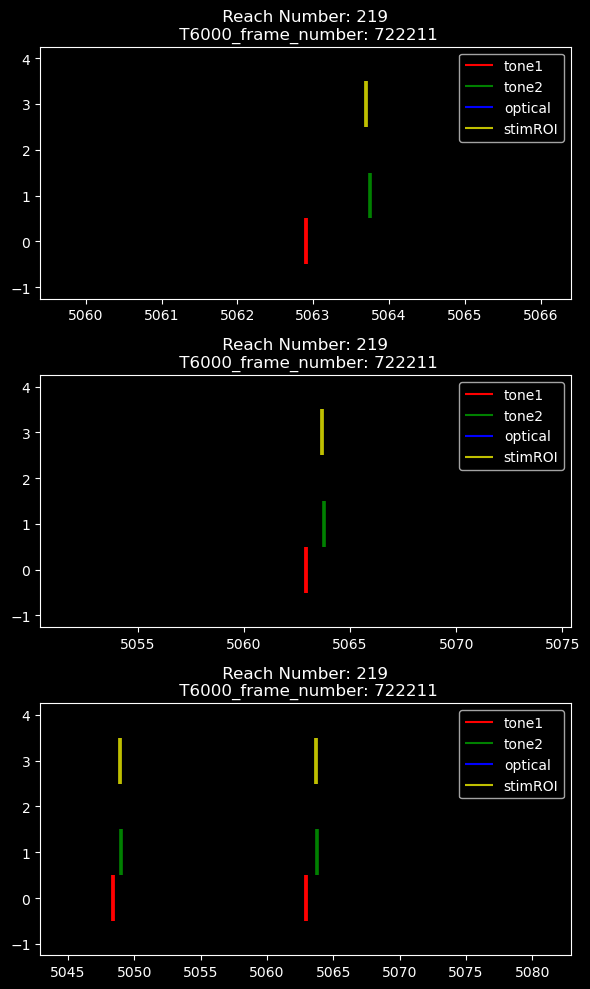

In [308]:
reach_event_save_path_03 = reach_event_save_path + '\\3_combined_reach_events'

if reach_event_save_path_03+f'\\reach_1.png' in glob.glob(reach_event_save_path_03+f'\\reach_*.png'):
    print('Files / plots already exist')
    print('either delete the plots or change the save path')

else:
    if not os.path.exists(reach_event_save_path_03):
        os.makedirs(reach_event_save_path_03)
        print('Directory created: ', reach_event_save_path_03)
    fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(6,10))

    for i in range(len(tone1_timestamps)):
        
        axs[0].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[0].set_xlim(tone1_timestamps[i]-3.5, tone1_timestamps[i]+3.5)
        axs[0].legend(['tone1','tone2', 'optical','stimROI'])
        axs[0].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[1].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[1].set_xlim(tone1_timestamps[i]-12.5, tone1_timestamps[i]+12.5)
        axs[1].legend(['tone1','tone2', 'optical','stimROI'])
        axs[1].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[2].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[2].set_xlim(tone1_timestamps[i]-20, tone1_timestamps[i]+20)
        axs[2].legend(['tone1','tone2', 'optical','stimROI'])
        axs[2].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        plt.tight_layout()

        plt.savefig(reach_event_save_path_03+f'\\reach_{i}.png')

## End of plotting 

### using the number of rows recorded in the frame_events dataframe, we can calculate the total number of frames recorded, since each row is equivalent to one frame. we can use this to find total recording duration in seconds

In [45]:
row_numbers = np.arange(1, len(ni_df[ni_df['line'] == 8]) + 1)
open_ephys_frames = row_numbers
frames_in_seconds_open_ephys = np.array(row_numbers) / 150
frames_in_seconds_open_ephys[0:5]


array([0.00666667, 0.01333333, 0.02      , 0.02666667, 0.03333333])

### This shows the number of frames recoded by the camera in the open ephys. because the camera is recording at 150 fps, we can divide the frame number by 150 to get the time in seconds. and because i start the behavior camera and end the behvior camera begins after starting and ending the open ephys recording, there will be time in the open ephys recording before the frames start getting recorded.

In [46]:
open_ephys_frames_count = frame_events.shape[0]
print("number of frames recorded by open ephys:", open_ephys_frames_count)
print('number of frames recorded in txt file / total camera frames:', len(frames))
print('difference between open ephys frames and txt file frames:', len(frame_numbers) - open_ephys_frames_count)
print('')
print('duration of open ephys recording in seconds:', open_ephys_frames_count/150)
print('duration of open ephys recording in minutes:', open_ephys_frames_count/150/60)
print('')
print('duration of camera recording in seconds:', len(frame_numbers)/150)
print('duration of camera recording in minutes:', len(frame_numbers)/150/60)

number of frames recorded by open ephys: 727088
number of frames recorded in txt file / total camera frames: 726965
difference between open ephys frames and txt file frames: -123

duration of open ephys recording in seconds: 4847.253333333333
duration of open ephys recording in minutes: 80.78755555555556

duration of camera recording in seconds: 4846.433333333333
duration of camera recording in minutes: 80.77388888888889


In [47]:
extra_frames_counted_by_open_ephys =  open_ephys_frames_count - txt_file_frame_count
print("number of extra frames recorded by open-ephys:", extra_frames_counted_by_open_ephys)
print("seconds of extra frames recorded by open-ephys", extra_frames_counted_by_open_ephys/150)
print("minutes of extra frames recorded by open-ephys", extra_frames_counted_by_open_ephys/150/60)

number of extra frames recorded by open-ephys: 123
seconds of extra frames recorded by open-ephys 0.82
minutes of extra frames recorded by open-ephys 0.013666666666666666


### use the recorded frame event in the txt file and index into the corrisponding row of the frame_events dataframe and grab the time from the timestamp column. this gived you the aligned time in which the event occured, meaning you can use that time to plot the data, because it is syncronized with the neuropixel clocks

In [48]:
# print("Pellet Detected frame number:", pellet_detected_frame)
# print("Pellet Delivery frame number:", pellet_delivery_frame)

# print('')


# # Create new arrays to store the extracted timestamps
# detected_timestamps = []
# delivery_timestamps = []
# # Iterate through the frames in the 'pellet_detected_frame' array
# for frame in pellet_detected_frame:
#     # Use the frame value as an index to select the corresponding row
#     selected_row = frame_events.iloc[frame]
#     timestamp = selected_row['timestamp']
#     detected_timestamps.append(timestamp)

# # Iterate through the frames in the 'pellet_delivery_frame' array
# for frame in pellet_delivery_frame:
#     # Use the frame value as an index to select the corresponding row
#     selected_row = frame_events.iloc[frame]
#     timestamp = selected_row['timestamp']
#     delivery_timestamps.append(timestamp)

# # Now, 'detected_timestamps' and 'delivery_timestamps' contain the extracted timestamps
# print("Pellet Detected Timestamps:", detected_timestamps)
# print("Pellet Delivery Timestamps:", delivery_timestamps)
# print('total pellet delivery :', len(delivery_timestamps))
# print('total pellet detected :', len(detected_timestamps))



In [49]:
# # Divide each value by 150
# pellet_detected_seconds = [value / 150 for value in pellet_detected_frame_new]
# pellet_delivery_seconds = [value / 150 for value in pellet_delivery_frame_new]

# print("pellet_detected_seconds: ", pellet_detected_seconds)
# print("pellet_delivery_seconds: ", pellet_delivery_seconds)

# These are the aligned timestamps of the pellet detected and pellet delivery events
### use these when plotting neural data

In [50]:
# event_times_pellet_detetced = frame_events['timestamp'].iloc[pellet_detected_frame_new]
# print(event_times_pellet_detetced)

# event_times_pellet_delivery = frame_events['timestamp'].iloc[pellet_delivery_frame_new]
# event_times_pellet_delivery

### Plot the digital line inputs

In [51]:
ni_ts = {}
df_up = ni_df[ni_df.state==1]
for ch in ni_df.line.unique():
    ni_ts[ch] = df_up[df_up.line == ch].timestamp

## plot of digital events. Line 8 is the camera frame trigger, line 5 is the tone1 and tone2, line 6 is just tone2, line 4 is the optical pulses

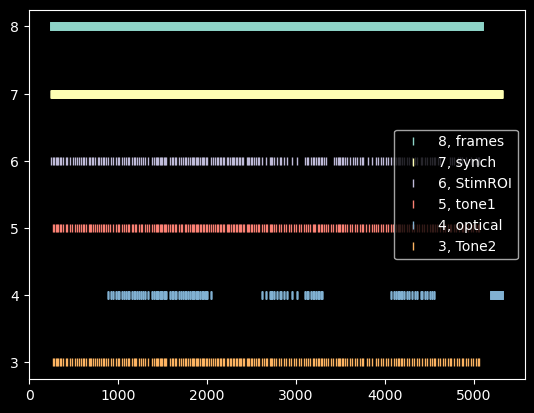

In [52]:
ch_name = ['8, frames', '7, synch', '6, StimROI','5, tone1', '4, optical', '3, Tone2']
i=0
for ch in ([8,7,6,5,4,3]):
    # plt.xlim(65,75)
    plt.plot(np.array(ni_ts[ch]),
             np.ones(len(ni_ts[ch]))*ch,
             '|',label=ch_name[i])

    i+=1
plt.legend()


In [53]:
# Convert the values to float
pellet_detected_frame = [float(frame) for frame in pellet_detected_frame]
pellet_delivery_frame = [float(frame) for frame in pellet_delivery_frame]


In [54]:
# detected_baseline = pellet_detected_seconds[0:2]
# detected_perturbation = pellet_detected_seconds[2:4]
# detected_washout = pellet_detected_seconds[4:6]
# print(detected_baseline, detected_perturbation, detected_washout)

# pellet_detected_slow_motion_baseline = pellet_detected_slow_motion[0:2] 
# pellet_detected_slow_motion_perturbation = pellet_detected_slow_motion[2:4]
# pellet_detected_slow_motion_washout = pellet_detected_slow_motion[4:6]
# print(pellet_detected_slow_motion_baseline, pellet_detected_slow_motion_perturbation, pellet_detected_slow_motion_washout)



In [55]:
# delivery_baseline = pellet_delivery_seconds[0:2]
# delivery_perturbation = pellet_delivery_seconds[2:4]
# delivery_washout = pellet_delivery_seconds[4:6]
# print(delivery_baseline, delivery_perturbation, delivery_washout)

# pellet_delivery_slow_motion_baseline = pellet_delivery_slow_motion[0:2]
# pellet_delivery_slow_motion_perturbation = pellet_delivery_slow_motion[2:4]
# pellet_delivery_slow_motion_washout = pellet_delivery_slow_motion[4:6]
# pellet_delivery_slow_motion_baseline, pellet_delivery_slow_motion_perturbation, pellet_delivery_slow_motion_washout

### Create a dictionary to store the data (this is the detialed option)
- Run this cell if you want the nwb to have all of this data

In [56]:


# stimuli_times = { 'pellet_delivery_seconds_txt': pellet_delivery_seconds,
#                 'pellet_detected_seconds_txt': pellet_detected_seconds,
#                 'pellet_delivery_slow_motion_txt': pellet_delivery_slow_motion,
#                 'pellet_detected_slow_motion_txt': pellet_detected_slow_motion,
#                 'pellet_detected_timestamp': tone1_timestamps,
#                 'pellet_delivery_timestamp': tone2_timestamps,
#                 'frame_events_timestamp': frame_events_timestamp,
#                 # 'pellet_delivery_baseline':delivery_baseline,
#                 # 'pellet_detected_perturbation':detected_perturbation,
#                 # 'pellet_delivery_perturbation':delivery_perturbation,
#                 # 'pellet_detected_washout':detected_washout,
#                 # 'pellet_delivery_washout':delivery_washout,
#                 # 'pellet_detected_slow_motion_baseline':pellet_delivery_slow_motion_baseline,
#                 # 'pellet_detected_slow_motion_perturbation':pellet_delivery_slow_motion_perturbation,
#                 # 'pellet_detected_slow_motion_washout':pellet_delivery_slow_motion_washout,
#                 'all_frames_sideCam_txt':frame_numbers,
#                 'frames_in_seconds_openEphys':frames_in_seconds_open_ephys,

#                   }




### Create a dictionary to store the data (this is the simple option)
- Run this cell if you want the nwb to have less data

In [57]:
stimuli_times_simple = { 'tone1_timestamps': tone1_timestamps,
                'tone2_timestamps': tone2_timestamps,
                'stimROI_timestamps': stimROI_timestamps,
                'frame_events_timestamp': frame_timestamps,
                'all_frames_sideCam_txt':frame_numbers,
                'frames_in_seconds_openEphys':frames_in_seconds_open_ephys,
                'optical_timestamps': optical_timestamps,

                  }

### Conver values to floats, for code to work, idk why

In [58]:
# Convert the 'frames' values to float
# stimuli_times['all_frames_sideCam_txt'] = [float(frame) for frame in stimuli_times['all_frames_sideCam_txt']]


# # Now, the 'frames' values are in float format
# print(stimuli_times['all_frames_sideCam_txt'])

In [59]:
# Convert the 'frames' values to float
stimuli_times_simple['all_frames_sideCam_txt'] = [float(frame) for frame in stimuli_times_simple['all_frames_sideCam_txt']]


# # Now, the 'frames' values are in float format
# print(stimuli_times_simple['all_frames_sideCam_txt'])

In [60]:

#stimulus list
stimuli = {'none': None,
           } 

## Assemble NWB

In [61]:
# !pip install pynwb
# !pip install numpy==1.24.3


In [62]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [63]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

print(experiment_description)

nwbfile = NWBFile(experiment_description, 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Christie Lab',
                  institution='University of Colorado Anschtuz Medical Campus',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively


### add stimulus information
- choose to run either the stimuli_times or stimuli_times_simple cell bellow (you can only run one, and that will decidce whats in your nwb)

In [64]:
# for stim in stimuli_times.keys():
#     nwbfile.add_epoch(np.array(stimuli_times[stim])[0], 
#                       np.array(stimuli_times[stim])[-1]+3.,
#                       [stim])

In [65]:
for stim in stimuli_times_simple.keys():
    nwbfile.add_epoch(np.array(stimuli_times_simple[stim])[0], 
                      np.array(stimuli_times_simple[stim])[-1]+3.,
                      [stim])

In [66]:
nwbfile

root pynwb.file.NWBFile at 0x2662997805664
Fields:
  epoch_tags: {
    all_frames_sideCam_txt,
    frame_events_timestamp,
    frames_in_seconds_openEphys,
    optical_timestamps,
    stimROI_timestamps,
    tone1_timestamps,
    tone2_timestamps
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively
  experimenter: ['grh']
  file_create_date: [datetime.datetime(2025, 1, 1, 17, 32, 42, 749883, tzinfo=tzlocal())]
  identifier: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008
  institution: University of Colorado Anschtuz Medical Campus
  lab: Christie Lab
  session_d

## Run for stimuli_times 

In [67]:
### Uncomment for 

In [68]:
# nwbfile.add_trial_column('stimulus', 'the event occuring during this trial')
# #optogenetic pertibation
# nwbfile.add_trial_column('optogenetics_LED_state', 'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')
# #arbMatrix and scene flicker
# # nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')
# stim_vals = {'optogenetics_LED_state':-1,
       
# }
        
# stim = 'all_frames_sideCam_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )   
# stim = 'frames_in_seconds_openEphys'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_seconds_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_seconds_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_slow_motion_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_slow_motion_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'frame_events_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )

    

In [69]:
nwbfile

root pynwb.file.NWBFile at 0x2662997805664
Fields:
  epoch_tags: {
    all_frames_sideCam_txt,
    frame_events_timestamp,
    frames_in_seconds_openEphys,
    optical_timestamps,
    stimROI_timestamps,
    tone1_timestamps,
    tone2_timestamps
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively
  experimenter: ['grh']
  file_create_date: [datetime.datetime(2025, 1, 1, 17, 32, 42, 749883, tzinfo=tzlocal())]
  identifier: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008
  institution: University of Colorado Anschtuz Medical Campus
  lab: Christie Lab
  session_d

## Run for stimuli_times_simple

In [70]:
len(tone1_timestamps), len(tone2_timestamps), len(frame_timestamps), len(frame_numbers), len(frames_in_seconds_open_ephys)

(219, 216, 727088, 726965, 727088)

In [71]:
nwbfile.add_trial_column('stimulus', 'the event occuring during this trial')

#optogenetic pertibation
nwbfile.add_trial_column('optogenetics_LED_state', 'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')


In [72]:

#arbMatrix and scene flicker
# nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')

stim_vals = {'optogenetics_LED_state':-1,
       
}


    
stim = 'tone1_timestamps'
for i, trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start, stimulus=stim,
                    optogenetics_LED_state=0)
    
stim = 'tone2_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,

                     )
    
stim = 'stimROI_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,

                     )

stim = 'frame_events_timestamp'
total_trials = len(stimuli_times_simple[stim])
for i, trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start, stimulus=stim,
                      optogenetics_LED_state=0)


stim = 'optical_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,)

#                      )
# print(f'here 2: {nwbfile.trials}')


# stim = 'all_frames_sideCam_txt'
# for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )   

## Check the trials dataframe

In [74]:
df = nwbfile.trials.to_dataframe()


In [75]:
df[0:15]

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0
5,339.803562,339.803562,tone1_timestamps,0
6,354.052815,354.052815,tone1_timestamps,0
7,382.319250,382.319250,tone1_timestamps,0
8,410.573784,410.573784,tone1_timestamps,0


In [76]:

tone1_data = df[df['stimulus'] == 'tone1_timestamps']
tone2_data = df[df['stimulus'] == 'tone2_timestamps']
stimROI_data = df[df['stimulus'] == 'stimROI_timestamps']
pellet_delivery_slow_motion = df[df['stimulus'] == 'pellet_delivery_slow_motion_txt']
pellet_detected_slow_motion = df[df['stimulus'] == 'pellet_detected_slow_motion_txt']
all_frames_sideCam = df[df['stimulus'] == 'all_frames_sideCam_txt']
frames_in_seconds_openEphys = df[df['stimulus'] == 'frames_in_seconds_openEphys']
optical_timestamps = df[df['stimulus'] == 'optical_timestamps']


In [77]:
tone1_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0


In [78]:
tone2_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
219,265.894271,265.894271,tone2_timestamps,0
220,280.396529,280.396529,tone2_timestamps,0
221,295.145770,295.145770,tone2_timestamps,0
222,310.155104,310.155104,tone2_timestamps,0
223,324.651276,324.651276,tone2_timestamps,0


In [79]:
stimROI_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
435,247.710327,247.710327,stimROI_timestamps,0
436,266.478939,266.478939,stimROI_timestamps,0
437,280.673692,280.673692,stimROI_timestamps,0
438,295.975223,295.975223,stimROI_timestamps,0
439,310.123828,310.123828,stimROI_timestamps,0


In [80]:
all_frames_sideCam.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,


In [81]:
frames_in_seconds_openEphys.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,


In [82]:
optical_timestamps.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
727723,884.348338,884.348338,optical_timestamps,0
727724,884.353338,884.353338,optical_timestamps,0
727725,884.358338,884.358338,optical_timestamps,0
727726,884.363339,884.363339,optical_timestamps,0
727727,884.368339,884.368339,optical_timestamps,0


## add optogenetics

In [83]:
optical_events.head()

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
108486,4,35389461,884.348338,102,9,PXIe-6341,1
108488,4,35389661,884.353338,102,9,PXIe-6341,0
108491,4,35389861,884.358338,102,9,PXIe-6341,1
108493,4,35390061,884.363339,102,9,PXIe-6341,0
108495,4,35390261,884.368339,102,9,PXIe-6341,1


In [84]:

# opto_on_times = delivery_pert_df['start_time'].to_numpy()
# opto_off_times = [value + 0.1 for value in opto_on_times]

# opto_on_times, opto_off_times


In [85]:
# frame_events 

# opto_off_times = detected_pert_df[camera_df.state==0].timestamp
# opto_on_times = camera_df[camera_df.state==1].timestamp

In [86]:
# opto_states = pynwb.epoch.TimeIntervals(
#     name="optogenetics_states",
#     description="intervals for optical fiber, fiber at power = ?? on what system. fiber 470nm, ",
# )

# opto_states.add_column(name="power", description="15mW")
# opto_states.add_column(name="wavelength", description="470nm")

# for i in range(np.array(opto_off_times).shape[0]):
#     opto_states.add_row(start_time=np.array(opto_on_times)[i], stop_time=np.array(opto_off_times)[i], power=1.5, wavelength=565)

# nwbfile.add_time_intervals(opto_states)

### add ephys data
first add electrodes and raw data link

In [87]:
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data


ImportError: cannot import name 'boxcar' from 'scipy.signal' (c:\Users\user\anaconda3\envs\reaching_task\lib\site-packages\scipy\signal\__init__.py)

In [188]:
# df_units = multi_load_unit_data(recording_folder,probe_depths=probedepths)
# df_units.iloc[0]

#### This is setting the recording_folder to the correct location for the NWB
- recording_folder needs to include \Record Node 103\experiment1\recording1\continuous to work

In [91]:
recording_folder = root_recording_folder + r"\Record Node 103\experiment1\recording1\continuous"
print(recording_folder)

G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous


##### The cell bellow needs to print contents for each probe like shown bellow
- Contents: ['Neuropix-PXI-100.ProbeA-AP', 'Neuropix-PXI-100.ProbeA-LFP', 'Neuropix-PXI-100.ProbeB-AP', 'Neuropix-PXI-100.ProbeB-LFP', 'Neuropix-PXI-100.ProbeC', 'Neuropix-PXI-100.ProbeD-AP', 'Neuropix-PXI-100.ProbeD-LFP', 'Neuropix-PXI-100.ProbeE-AP', 'Neuropix-PXI-100.ProbeE-LFP', 'NI-DAQmx-102.PXIe-6341']


In [94]:
import os

# recording_folder = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\continuous"
print("Looking in:", recording_folder)
print("Contents:", os.listdir(recording_folder))

Looking in: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous
Contents: ['Neuropix-PXI-100.ProbeA-AP', 'Neuropix-PXI-100.ProbeA-LFP', 'Neuropix-PXI-100.ProbeB-AP', 'Neuropix-PXI-100.ProbeB-LFP', 'Neuropix-PXI-100.ProbeC', 'Neuropix-PXI-100.ProbeD-AP', 'Neuropix-PXI-100.ProbeD-LFP', 'Neuropix-PXI-100.ProbeE-AP', 'Neuropix-PXI-100.ProbeE-LFP', 'NI-DAQmx-102.PXIe-6341']


## Make layout for NP2-4-shank

In [95]:
import numpy as np

# Create empty array for 4-shank layout
positions = np.zeros((384, 2))

# Define constants
col_spacing = 32  # Column spacing in microns
row_spacing = 15  # Row spacing in microns
shank_spacing = 250  # Spacing between shanks in microns

# Shank 1: Channels 47–96
shank1_start_idx = 46
for i in range(25):  # 25 rows
    positions[shank1_start_idx + i, 0] = 0  # Column 1
    positions[shank1_start_idx + i, 1] = (i + 23) * row_spacing  # Row spacing
    positions[shank1_start_idx + i + 25, 0] = col_spacing  # Column 2
    positions[shank1_start_idx + i + 25, 1] = (i + 23) * row_spacing

# Shank 2: Channels 1–141
shank2_start_idx = 0
for i in range(71):  # 71 rows
    positions[shank2_start_idx + i, 0] = shank_spacing  # Column 1
    positions[shank2_start_idx + i, 1] = i * row_spacing
    positions[shank2_start_idx + i + 71, 0] = shank_spacing + col_spacing  # Column 2
    positions[shank2_start_idx + i + 71, 1] = i * row_spacing

# Shank 3: Channels 1–141 (same as Shank 2)
shank3_start_idx = 142
for i in range(71):  # 71 rows
    positions[shank3_start_idx + i, 0] = 2 * shank_spacing  # Column 1
    positions[shank3_start_idx + i, 1] = i * row_spacing
    positions[shank3_start_idx + i + 71, 0] = 2 * shank_spacing + col_spacing  # Column 2
    positions[shank3_start_idx + i + 71, 1] = i * row_spacing

# Shank 4: Channels 47–96 (same as Shank 1)
shank4_start_idx = 284
for i in range(25):  # 25 rows
    positions[shank4_start_idx + i, 0] = 3 * shank_spacing  # Column 1
    positions[shank4_start_idx + i, 1] = (i + 23) * row_spacing
    positions[shank4_start_idx + i + 25, 0] = 3 * shank_spacing + col_spacing  # Column 2
    positions[shank4_start_idx + i + 25, 1] = (i + 23) * row_spacing

positions


array([[ 250.,    0.],
       [ 250.,   15.],
       [ 250.,   30.],
       [ 250.,   45.],
       [ 250.,   60.],
       [ 250.,   75.],
       [ 250.,   90.],
       [ 250.,  105.],
       [ 250.,  120.],
       [ 250.,  135.],
       [ 250.,  150.],
       [ 250.,  165.],
       [ 250.,  180.],
       [ 250.,  195.],
       [ 250.,  210.],
       [ 250.,  225.],
       [ 250.,  240.],
       [ 250.,  255.],
       [ 250.,  270.],
       [ 250.,  285.],
       [ 250.,  300.],
       [ 250.,  315.],
       [ 250.,  330.],
       [ 250.,  345.],
       [ 250.,  360.],
       [ 250.,  375.],
       [ 250.,  390.],
       [ 250.,  405.],
       [ 250.,  420.],
       [ 250.,  435.],
       [ 250.,  450.],
       [ 250.,  465.],
       [ 250.,  480.],
       [ 250.,  495.],
       [ 250.,  510.],
       [ 250.,  525.],
       [ 250.,  540.],
       [ 250.,  555.],
       [ 250.,  570.],
       [ 250.,  585.],
       [ 250.,  600.],
       [ 250.,  615.],
       [ 250.,  630.],
       [ 25

### For some reason running multi_load_unit_data() from dlabs.nwbtools is not working. so i had to copy over the function and run it here. that is what the big cell below is for. ignore it, it just allows the df_units to run undernearh it
### The bellow cell is here because the  multi_load_unit_data() function from dlab.nwbtools is not working
-   its an issue with the units_time.append line, it cant add the amplitudes because of a dimension issue
-   'amplitudes': amplitudes[:,0][spike_clusters==unitID],

In [96]:
# import numpy as np
# import pandas as pd
# import warnings
# import glob, os, h5py, csv
# # from dlab.generalephys import option234_positions
# from dlab.sglx_analysis import readAPMeta
# import dlab.continuous_traces as ct

# option234_positions = np.zeros((384,2))

# try:
# 	from nwb.nwb import NWB
# 	from nwb.nwbts import TimeSeries
# except:
# 	print('no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse')
# try:
# 	from djd.OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
# except:
# 	try:
# 		from OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
# 	except:
# 		print('no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools')

# warnings.simplefilter(action='ignore', category=FutureWarning)
		
# def load_phy_template(path,cluster_file='KS2',site_positions = option234_positions, **kwargs):
# 	"""load spike data that has been manually sorted with the phy-template GUI

#     Parameters
#     ----------
#     path : string
#         the path to the sorted data
#     cluster_file : string, optional
#         the format of the cluter_info file. options, KS2, KS3
#     site_positions : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

#     Returns
#     -------
#     dict
# 		returns a dictionary of 'good' units, each of which includes:
# 			times: spike times, in seconds
# 			template: template used for matching
# 			ypos: y position on the probe, calculated from the template. requires an accurate site_positions. averages template from 100 spikes.
# 			xpos: x position on the probe, calcualted from the template. requires an accurate site_positions. averages template from 100 spikes.
# 	""" 
# 	clusters = np.load(open(os.path.join(path,'spike_clusters.npy'),'rb'))
# 	spikes = np.load(open(os.path.join(path,'spike_times.npy'),'rb'))
# 	spike_templates = np.load(open(os.path.join(path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(path,'templates.npy'),'rb'))
# 	cluster_id,KSlabel,KSamplitude,KScontamination = [],[],[],[]
# 	[KSlabel.append(row) for row in csv.reader(open(os.path.join(path,'cluster_KSLabel.tsv')))]
# 	[KSamplitude.append(row) for row in csv.reader(open(os.path.join(path,'cluster_Amplitude.tsv')))]
# 	[KScontamination.append(row) for row in csv.reader(open(os.path.join(path,'cluster_ContamPct.tsv')))]
# 	if os.path.isfile(os.path.join(path,'cluster_group.tsv')):
# 		# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))][1:]
# 		[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))]
# 	else:
# 		if os.path.isfile(os.path.join(path,'cluster_groups.csv')):
# 			# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))][1:]
# 			[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))]
# 		else: print('cant find cluster groups, either .tsv or .csv')
# 	if 'sampling_rate' in kwargs.keys():
# 		samplingrate = kwargs['sampling_rate']
# 	else:
# 		samplingrate =30000.
# 		# print('no sampling rate specified, using default of 30kHz')
		
# 	units = {}
# 	for i in np.arange(1,np.shape(cluster_id)[0]):
# 		unit = int(cluster_id[i][0].split('\t')[0])
# 		units[str(unit)] = {}
		
# 		#get the unit spike times
# 		units[str(unit)]['samples'] = spikes[np.where(clusters==unit)].flatten()
# 		units[str(unit)]['times'] = spikes[np.where(clusters==unit)]/samplingrate
# 		units[str(unit)]['times'] = units[str(unit)]['times'].flatten()
		
# 		#get the mean template used for this unit
# 		all_templates = spike_templates[np.where(clusters==unit)].flatten()
# 		n_templates_to_subsample = 100
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)
# 		units[str(unit)]['template'] = mean_template
		
# 		#take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
# 		#this gets us the x and y positions of the unit on the probe.
# 		# print(mean_template.T.shape)
# 		weights = np.zeros(site_positions.shape)
# 		for channel in range(mean_template.T.shape[0]):
# 			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
# 		weights = weights/np.max(weights)
# 		low_values_indices = weights < 0.25  # Where values are low,
# 		weights[low_values_indices] = 0      # make the weight 0
# 		(xpos,ypos)=np.average(site_positions,axis=0,weights=weights)
# 		units[str(unit)]['waveform_weights'] = weights
# 		units[str(unit)]['xpos'] = xpos
# 		units[str(unit)]['ypos'] = ypos #- site_positions[-1][1]
# 		units[str(unit)]['label'] =  cluster_id[i][0].split('\t')[1]
# 		units[str(unit)]['KSlabel'] =  KSlabel[i][0].split('\t')[1]
# 		units[str(unit)]['KSamplitude'] =  KSamplitude[i][0].split('\t')[1]
# 		units[str(unit)]['KScontamination'] =  KScontamination[i][0].split('\t')[1]
# 	return units

# def df_from_phy(path,site_positions = option234_positions,**kwargs):
# 	"""load spike data that has been manually sorted with the phy-template GUI

#     Parameters
#     ----------
#     path : string
#         the path to the sorted data
#     cluster_file : string, optional
#         the format of the cluter_info file. options, KS2, KS3
#     site_positions : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

#     Returns
#     -------
#     pandas DataFrame
# 		returns a DataFrame of 'good' units, each of which includes:
# 	"""
# 	nwb_data = load_phy_template(path,site_positions)
# 	#structures is a dictionary that defines the bounds of the structure e.g.:{'v1':(0,850), 'hpc':(850,2000)}
# 	mouse = [];experiment=[];cell = [];ypos = [];xpos = [];waveform=[];template=[];structure=[];times=[]
# 	index = []; count = 1
# 	nwb_id = [];probe_id=[]
# 	depth=[];#print(list(nwb_data.keys()));print(list(nwb_data['processing'].keys()));
# 	if 'probe' in kwargs.keys():
# 		for probe in list(nwb_data['processing'].keys()):
# 			if 'UnitTimes' in list(nwb_data['processing'][probe].keys()): 
# 				for i,u in enumerate(list(nwb_data['processing'][probe]['UnitTimes'].keys())):
# 					if u != 'unit_list':
# 						nwb_id.append(nwbid)
# 						probe_id.append(probe)
# 						index.append(count);count+=1
# 						mouse.append(str(np.array(nwb_data.get('identifier'))))
# 						experiment.append(1)
# 						cell.append(u)
# 						times.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['times']));# print(list(nwb_data['processing'][probe]['UnitTimes'][u].keys()))
# 						if 'ypos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							ypos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
# 							has_ypos = True
# 						else:
# 							ypos.append(None)
# 							has_ypos = False				
# 						if 'depth' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['depth']))
# 						else:
# 							if has_ypos:
# 								depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
# 							else:
# 								depth.append(None)
# 						if 'xpos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							xpos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['xpos']))
# 							has_xpos = True
# 						else:
# 							xpos.append(None)
# 							has_xpos = False
# 						template.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['template']))
# 						waveform.append(get_peak_waveform_from_template(template[-1]))
# 						if not structures == None:
# 							structur = None
# 							for struct, bounds in structures.iteritems():
# 								if ypos[-1] > bounds[0] and ypos[-1]< bounds[1] :
# 									structur=struct
# 						else:
# 							structur = None
# 						structure.append(structur)
# 	df = pd.DataFrame(index=index)
# 	df = df.fillna(np.nan)
# 	df['nwb_id'] = nwb_id
# 	df['mouse'] = mouse
# 	df['experiment'] = experiment
# 	df['probe'] = probe_id
# 	df['structure'] = structure
# 	df['cell'] = cell
# 	df['times'] = times
# 	df['ypos'] = ypos
# 	df['xpos'] = xpos
# 	df['depth'] = depth
# 	df['waveform'] = waveform
# 	df['template'] = template
# 	return df

# def load_unit_data(recording_path, probe_depth = 3840, site_positions = option234_positions, 
#                    probe_name=None, spikes_filename = 'spike_secs.npy', aligned=True, df=True, **kwargs):
# 	"""DEPRECATED
	
# 	"""
	
# 	if probe_name == None: probe_name = recording_path
#     #Get individual folders for each probe
# 	unit_times=[]
# 	if aligned == False:
# 		if 'sampling_rate' in kwargs.keys():
# 			sampRate  = float(kwargs['sampling_rate'])
# 		else:
# 			sampRate=30000
# 		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_times.npy')))/sampRate
# 	else:
# 		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, spikes_filename)))

# 	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
# 	if cluster_info.keys()[0]=='cluster_id':
# 		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
# 	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
# 	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
# 	amplitudes = np.load(open(os.path.join(recording_path,'amplitudes.npy'),'rb'))
# 	weights = np.zeros(site_positions.shape)
# 	 # Debugging information

#     #Generate Unit Times Table
# 	for index, unitID in enumerate(cluster_info['id'].values):
#         #get mean template used for each unit
# 		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
# 		n_templates_to_subsample = 100
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)

#         #take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
#         #this gets us the x and y positions of the unit on the probe.
# 		for channel in range(mean_template.T.shape[0]):
# 			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
# 		weights = weights/np.max(weights)
# 		low_values_indices = weights < 0.25  # Where values are low,
# 		weights[low_values_indices] = 0      # make the weight 0
# 		(xpos,zpos)=np.average(site_positions,axis=0,weights=weights)

# 		 # Add debugging statements


# 		unit_times.append({'probe':probe_name,
#                            'unit_id': unitID,
#                            'group': cluster_info.group[index],
# #                                'depth':cluster_info.depth[index],
#                            'depth': (zpos-3840)+probe_depth,
#                            'xpos': xpos,
#                            'zpos': zpos,
#                            'no_spikes': cluster_info.n_spikes[index], 
#                            'KSlabel': cluster_info['KSLabel'][index],
#                            'KSamplitude':cluster_info.Amplitude[index],
#                            'KScontamination': cluster_info.ContamPct[index],
#                            'template': mean_template,
#                            'waveform_weights': weights,
#                            #'amplitudes': amplitudes[:,0][spike_clusters==unitID],
#                            'spike_times': spike_times[spike_clusters == unitID],
#                             })
# 	if df == True:        
# 		unit_data = pd.DataFrame(unit_times)
#         #Remove clusters with no associated spike times left over from Phy
# 		for i,j in enumerate(unit_data.spike_times):
# 			if len(unit_data.spike_times[i])==0:
# 				unit_data.spike_times[i]='empty'
# 		unit_times = unit_data[unit_data.spike_times!='empty']
# 		return(unit_times)
# 	else:
# 		return(unit_times)

# def load_unit_data_from_phy(recording_path,chanmap=None,insertion_depth = 3840,insertion_angle = 0):	
# 	"""requires that phy has been run to generate cluster_info.tsv
# 	   searches the folder for the chanmap the KS used, or searches one folder up for it

#     Parameters
#     ----------
#     recording_path : string
#         the path to the sorted data
#     chanmap : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe
#     insertion_depth : int, optional
#         the depth in microns of the insertion
#     insertion_depth : int, optional
#         the angle, away from normal to the brain surface, of the insertion. used in calculating depth from puea

#     Returns
#     -------
#     cluster_info : dict
# 		returns a dictionary of 'good' units
# 	""" 
# 	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
# 	if cluster_info.keys()[0]=='cluster_id':
# 		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
# 	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
# 	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
# 	spike_times = np.load(open(os.path.join(recording_path,'spike_times.npy'),'rb'))
# 	timestamps = np.load(open(os.path.join(recording_path,'timestamps.npy'),'rb'))
# 	spike_secs = timestamps[spike_times.flatten()]

#     #parse spike times for each unit. also get the template so we can use it for waveform shape clustering
# 	times = []
# 	mean_templates = []
# 	for unitID in cluster_info.id.values:
# 		times.append(spike_secs[spike_clusters == unitID])

# 		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
# 		if len(all_templates) > 100:
# 			n_templates_to_subsample = 100
# 		else: n_templates_to_subsample = len(all_templates)
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)
# 		mean_templates.append(mean_template)
# 	cluster_info['times'] = times
# 	cluster_info['template'] = mean_templates
# 	cluster_info['depth_from_pia']=cluster_info.depth.values * -1 + insertion_depth*np.cos(np.deg2rad(insertion_angle))

# 	if chanmap == None:
# 		try:
# 			chanmap = loadmat(glob.glob(os.path.join(recording_path,'*hanMap.mat'))[0])
# 		except:
# 			chanmap = loadmat(glob.glob(os.path.join(os.path.dirname(recording_path),'*hanMap.mat'))[0])

# 	cluster_info['ycoords'] = chanmap['ycoords'].flatten()[cluster_info.ch.values]
# 	cluster_info['xcoords'] = chanmap['xcoords'].flatten()[cluster_info.ch.values]
# 	cluster_info['shank'] = np.floor(cluster_info['xcoords'].values / 205.).astype(int)

# 	return cluster_info

# def make_spike_secs(probe_folder):
# 	"""if a times of spikes, in seconds, have not been calculated (only samples), creates spike_secs.npy

#     Parameters
#     ----------
#     probe_folder : string
#         the path to the  folder containing sorted data and raw data

#     Returns
#     -------
#      None
# 	 saves, the probe_folder input, a new file called spike)secs.npy
# 	""" 

# 	c = np.load(os.path.join(probe_folder,'spike_times.npy'))
# 	try:
# 		a = np.load(os.path.join(probe_folder,'timestamps.npy'))
# 	except:
# 		try:
# 			a = np.load(os.path.join(probe_folder,'new_timestamps','timestamps.npy'))
# 		except: 
# 			try:
# 				print('could not find timestamps.npy, trying to recreate from the sync TTLs for '+probe_folder)
# 				ct.recreate_probe_timestamps_from_TTL(probe_folder)
# 				a = np.load(os.path.join(probe_folder,'new_timestamps','timestamps.npy'))
# 			except: print('could not find timestamps.npy')
# 	try:
# 		spike_secs = a[c.flatten()[np.where(c.flatten()<a.shape[0])]]
# 	except: 
# 		print(np.shape(a))
# 		print(np.shape(c.flatten()))
# 		print(np.shape(c))
# 		print('shape of spike times annd timestamps not compatible, check above and investigate.')
# 	np.save(open(os.path.join(probe_folder,'spike_secs.npy'),'wb'),spike_secs)


# def multi_load_unit_data(recording_folder,probe_names=['A','B','C','D','E'],probe_depths=[3840,3840,3840,3840,3840],NP_type=['NP1','NP1','NP1','NP1','NP1'],spikes_filename = 'spike_secs.npy', aligned=True):
# 	"""requires that phy has been run to generate cluster_info.tsv
# 	   searches the folder for the chanmap the KS used, or searches one folder up for it

#     Parameters
#     ----------
#     recording_folder : string
#         the path to the parent folder containing multiple simultaneous recordings. each folder contains sorted data
# 	probe_names : tuple-like, containing strings
#         the names of the probes in the recording folder
# 	probe_depths : tuple-like, containing ints
#         the depths of insertion of the probes in the recording folder
#     spikes_filename : string, optional
#         the name of the file containg times for each spike. default: 'spike_secs.npy'
#     aligned : bool, optional
#         whether the probes are temporally aligned. default True

#     Returns
#     -------
#      : pandas DataFrame
# 		a DataFrame containing good units from all recordings. also adds a column for probe of origin based on the `probe_names` input
# 	""" 
	
# 	folder_paths = glob.glob(os.path.join(recording_folder,'*imec*'))
# 	print(folder_paths)
# 	if len(folder_paths) > 0: spikes_filename = 'spike_secs.npy'
	
# 	else:
# 		folder_paths = glob.glob(os.path.join(recording_folder,'*AP*'))
# 		if len(folder_paths) > 0: 
# 			for probe_folder in folder_paths: make_spike_secs(probe_folder)
# 		else:
# 			print('did not find any recordings in '+recording_folder+'')
# 			return
# 	return pd.concat([load_unit_data(folder,probe_name=probe_names[i],probe_depth=probe_depths[i],spikes_filename = spikes_filename, aligned=True,df=True) for i,folder in enumerate(folder_paths)],ignore_index=True)






# def multi_load_unit_data_NP2(recording_folder, probe_names=['A', 'B', 'C', 'D', 'E'], 
#                          probe_depths=[3840, 3840, 3840, 3840, 3840], 
#                          NP_type=['NP1', 'NP1', 'NP1', 'NP1', 'NP1'], 
#                          spikes_filename='spike_secs.npy', aligned=True):
#     """
#     Requires that phy has been run to generate cluster_info.tsv.
#     Searches the folder for the chanmap the KS used, or searches one folder up for it.

#     Parameters
#     ----------
#     recording_folder : string
#         The path to the parent folder containing multiple simultaneous recordings. Each folder contains sorted data.
#     probe_names : tuple-like, containing strings
#         The names of the probes in the recording folder.
#     probe_depths : tuple-like, containing ints
#         The depths of insertion of the probes in the recording folder.
#     NP_type : list of strings, optional
#         The Neuropixels type for each probe ('NP1' or 'NP2'). Default is NP1 for all probes.
#     spikes_filename : string, optional
#         The name of the file containing times for each spike. Default: 'spike_secs.npy'.
#     aligned : bool, optional
#         Whether the probes are temporally aligned. Default: True.

#     Returns
#     -------
#     pandas.DataFrame
#         A DataFrame containing good units from all recordings, with an additional column for probe of origin.
#     """
#     def generate_np2_4shank_positions():
#         # Generate the 384x2 layout for NP2-4shank
#         positions = []
#         for shank_idx in range(4):
#             x_offset = shank_idx * 250  # Distance between shanks
#             for row_idx in range(71):  # 71 rows of channels per column for shank 2/3, 25 for shank 1/4
#                 y = row_idx * 15
#                 positions.append([x_offset, y])  # First column
#                 positions.append([x_offset + 32, y])  # Second column
#         return np.array(positions)

#     # Initialize positions for each probe based on NP_type
#     all_positions = []
#     for probe_type in NP_type:
#         if probe_type == 'NP1':
#             all_positions.append(option234_positions)  # Existing NP1 layout
#         elif probe_type == 'NP2':
#             all_positions.append(generate_np2_4shank_positions())
#         else:
#             raise ValueError(f"Unsupported NP_type: {probe_type}")

#     # Locate folders containing recordings
#     folder_paths = glob.glob(os.path.join(recording_folder, '*imec*'))
#     if not folder_paths:
#         folder_paths = glob.glob(os.path.join(recording_folder, '*AP*'))
#         if not folder_paths:
#             print(f"Did not find any recordings in {recording_folder}")
#             return
#         # Generate spike_secs.npy if not already present
#         for probe_folder in folder_paths:
#             make_spike_secs(probe_folder)

#     # Load data for each probe
#     result_dfs = []
#     for i, folder in enumerate(folder_paths):
#         result_dfs.append(load_unit_data(folder, 
#                                          probe_name=probe_names[i], 
#                                          probe_depth=probe_depths[i], 
#                                          site_positions=all_positions[i],
#                                          spikes_filename=spikes_filename, 
#                                          aligned=aligned, 
#                                          df=True))
#     return pd.concat(result_dfs, ignore_index=True)




#### This large uncommented cell is for instances when you had to create global_timestamps.nypy manually
- all the locations where the noraml timestamps.npy file name is used in the code, you will have to replace it with global_timestamps.npy
- therefore, Uncomment this cell bellow if you made a global_timestamps.npy
- AND comment out the large cell bellow it

#### Uncomment this large cell if you had to make gloabal_timestamps.npy
- ie. you timestamps were messed update_display
- in the code block that is uncommented, I replaced all the spots timestamps.npy with global_timestamps.npy 

In [97]:
# import numpy as np
# import pandas as pd
# import warnings
# import glob, os, h5py, csv
# # from dlab.generalephys import option234_positions
# from dlab.sglx_analysis import readAPMeta
# import dlab.continuous_traces as ct

# option234_positions = np.zeros((384,2))

# try:
# 	from nwb.nwb import NWB
# 	from nwb.nwbts import TimeSeries
# except:
# 	print('no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse')
# try:
# 	from djd.OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
# except:
# 	try:
# 		from OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
# 	except:
# 		print('no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools')

# warnings.simplefilter(action='ignore', category=FutureWarning)
		
# def load_phy_template(path,cluster_file='KS2',site_positions = option234_positions, **kwargs):
# 	"""load spike data that has been manually sorted with the phy-template GUI

#     Parameters
#     ----------
#     path : string
#         the path to the sorted data
#     cluster_file : string, optional
#         the format of the cluter_info file. options, KS2, KS3
#     site_positions : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

#     Returns
#     -------
#     dict
# 		returns a dictionary of 'good' units, each of which includes:
# 			times: spike times, in seconds
# 			template: template used for matching
# 			ypos: y position on the probe, calculated from the template. requires an accurate site_positions. averages template from 100 spikes.
# 			xpos: x position on the probe, calcualted from the template. requires an accurate site_positions. averages template from 100 spikes.
# 	""" 
# 	clusters = np.load(open(os.path.join(path,'spike_clusters.npy'),'rb'))
# 	spikes = np.load(open(os.path.join(path,'spike_times.npy'),'rb'))
# 	spike_templates = np.load(open(os.path.join(path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(path,'templates.npy'),'rb'))
# 	cluster_id,KSlabel,KSamplitude,KScontamination = [],[],[],[]
# 	[KSlabel.append(row) for row in csv.reader(open(os.path.join(path,'cluster_KSLabel.tsv')))]
# 	[KSamplitude.append(row) for row in csv.reader(open(os.path.join(path,'cluster_Amplitude.tsv')))]
# 	[KScontamination.append(row) for row in csv.reader(open(os.path.join(path,'cluster_ContamPct.tsv')))]
# 	if os.path.isfile(os.path.join(path,'cluster_group.tsv')):
# 		# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))][1:]
# 		[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))]
# 	else:
# 		if os.path.isfile(os.path.join(path,'cluster_groups.csv')):
# 			# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))][1:]
# 			[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))]
# 		else: print('cant find cluster groups, either .tsv or .csv')
# 	if 'sampling_rate' in kwargs.keys():
# 		samplingrate = kwargs['sampling_rate']
# 	else:
# 		samplingrate =30000.
# 		# print('no sampling rate specified, using default of 30kHz')
		
# 	units = {}
# 	for i in np.arange(1,np.shape(cluster_id)[0]):
# 		unit = int(cluster_id[i][0].split('\t')[0])
# 		units[str(unit)] = {}
		
# 		#get the unit spike times
# 		units[str(unit)]['samples'] = spikes[np.where(clusters==unit)].flatten()
# 		units[str(unit)]['times'] = spikes[np.where(clusters==unit)]/samplingrate
# 		units[str(unit)]['times'] = units[str(unit)]['times'].flatten()
		
# 		#get the mean template used for this unit
# 		all_templates = spike_templates[np.where(clusters==unit)].flatten()
# 		n_templates_to_subsample = 100
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)
# 		units[str(unit)]['template'] = mean_template
		
# 		#take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
# 		#this gets us the x and y positions of the unit on the probe.
# 		# print(mean_template.T.shape)
# 		weights = np.zeros(site_positions.shape)
# 		for channel in range(mean_template.T.shape[0]):
# 			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
# 		weights = weights/np.max(weights)
# 		low_values_indices = weights < 0.25  # Where values are low,
# 		weights[low_values_indices] = 0      # make the weight 0
# 		(xpos,ypos)=np.average(site_positions,axis=0,weights=weights)
# 		units[str(unit)]['waveform_weights'] = weights
# 		units[str(unit)]['xpos'] = xpos
# 		units[str(unit)]['ypos'] = ypos #- site_positions[-1][1]
# 		units[str(unit)]['label'] =  cluster_id[i][0].split('\t')[1]
# 		units[str(unit)]['KSlabel'] =  KSlabel[i][0].split('\t')[1]
# 		units[str(unit)]['KSamplitude'] =  KSamplitude[i][0].split('\t')[1]
# 		units[str(unit)]['KScontamination'] =  KScontamination[i][0].split('\t')[1]
# 	return units

# def df_from_phy(path,site_positions = option234_positions,**kwargs):
# 	"""load spike data that has been manually sorted with the phy-template GUI

#     Parameters
#     ----------
#     path : string
#         the path to the sorted data
#     cluster_file : string, optional
#         the format of the cluter_info file. options, KS2, KS3
#     site_positions : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

#     Returns
#     -------
#     pandas DataFrame
# 		returns a DataFrame of 'good' units, each of which includes:
# 	"""
# 	nwb_data = load_phy_template(path,site_positions)
# 	#structures is a dictionary that defines the bounds of the structure e.g.:{'v1':(0,850), 'hpc':(850,2000)}
# 	mouse = [];experiment=[];cell = [];ypos = [];xpos = [];waveform=[];template=[];structure=[];times=[]
# 	index = []; count = 1
# 	nwb_id = [];probe_id=[]
# 	depth=[];#print(list(nwb_data.keys()));print(list(nwb_data['processing'].keys()));
# 	if 'probe' in kwargs.keys():
# 		for probe in list(nwb_data['processing'].keys()):
# 			if 'UnitTimes' in list(nwb_data['processing'][probe].keys()): 
# 				for i,u in enumerate(list(nwb_data['processing'][probe]['UnitTimes'].keys())):
# 					if u != 'unit_list':
# 						nwb_id.append(nwbid)
# 						probe_id.append(probe)
# 						index.append(count);count+=1
# 						mouse.append(str(np.array(nwb_data.get('identifier'))))
# 						experiment.append(1)
# 						cell.append(u)
# 						times.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['times']));# print(list(nwb_data['processing'][probe]['UnitTimes'][u].keys()))
# 						if 'ypos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							ypos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
# 							has_ypos = True
# 						else:
# 							ypos.append(None)
# 							has_ypos = False				
# 						if 'depth' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['depth']))
# 						else:
# 							if has_ypos:
# 								depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
# 							else:
# 								depth.append(None)
# 						if 'xpos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
# 							xpos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['xpos']))
# 							has_xpos = True
# 						else:
# 							xpos.append(None)
# 							has_xpos = False
# 						template.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['template']))
# 						waveform.append(get_peak_waveform_from_template(template[-1]))
# 						if not structures == None:
# 							structur = None
# 							for struct, bounds in structures.iteritems():
# 								if ypos[-1] > bounds[0] and ypos[-1]< bounds[1] :
# 									structur=struct
# 						else:
# 							structur = None
# 						structure.append(structur)
# 	df = pd.DataFrame(index=index)
# 	df = df.fillna(np.nan)
# 	df['nwb_id'] = nwb_id
# 	df['mouse'] = mouse
# 	df['experiment'] = experiment
# 	df['probe'] = probe_id
# 	df['structure'] = structure
# 	df['cell'] = cell
# 	df['times'] = times
# 	df['ypos'] = ypos
# 	df['xpos'] = xpos
# 	df['depth'] = depth
# 	df['waveform'] = waveform
# 	df['template'] = template
# 	return df

# def load_unit_data(recording_path, probe_depth = 3840, site_positions = option234_positions, 
#                    probe_name=None, spikes_filename = 'spike_secs.npy', aligned=True, df=True, **kwargs):
# 	"""DEPRECATED
	
# 	"""
	
# 	if probe_name == None: probe_name = recording_path
#     #Get individual folders for each probe
# 	unit_times=[]
# 	if aligned == False:
# 		if 'sampling_rate' in kwargs.keys():
# 			sampRate  = float(kwargs['sampling_rate'])
# 		else:
# 			sampRate=30000
# 		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_times.npy')))/sampRate
# 	else:
# 		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, spikes_filename)))

# 	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
# 	if cluster_info.keys()[0]=='cluster_id':
# 		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
# 	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
# 	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
# 	amplitudes = np.load(open(os.path.join(recording_path,'amplitudes.npy'),'rb'))
# 	weights = np.zeros(site_positions.shape)
# 	 # Debugging information

#     #Generate Unit Times Table
# 	for index, unitID in enumerate(cluster_info['id'].values):
#         #get mean template used for each unit
# 		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
# 		n_templates_to_subsample = 100
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)

#         #take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
#         #this gets us the x and y positions of the unit on the probe.
# 		for channel in range(mean_template.T.shape[0]):
# 			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
# 		weights = weights/np.max(weights)
# 		low_values_indices = weights < 0.25  # Where values are low,
# 		weights[low_values_indices] = 0      # make the weight 0
# 		(xpos,zpos)=np.average(site_positions,axis=0,weights=weights)

# 		 # Add debugging statements


# 		unit_times.append({'probe':probe_name,
#                            'unit_id': unitID,
#                            'group': cluster_info.group[index],
# #                                'depth':cluster_info.depth[index],
#                            'depth': (zpos-3840)+probe_depth,
#                            'xpos': xpos,
#                            'zpos': zpos,
#                            'no_spikes': cluster_info.n_spikes[index], 
#                            'KSlabel': cluster_info['KSLabel'][index],
#                            'KSamplitude':cluster_info.Amplitude[index],
#                            'KScontamination': cluster_info.ContamPct[index],
#                            'template': mean_template,
#                            'waveform_weights': weights,
#                            #'amplitudes': amplitudes[:,0][spike_clusters==unitID],
#                            'spike_times': spike_times[spike_clusters == unitID],
#                             })
# 	if df == True:        
# 		unit_data = pd.DataFrame(unit_times)
#         #Remove clusters with no associated spike times left over from Phy
# 		for i,j in enumerate(unit_data.spike_times):
# 			if len(unit_data.spike_times[i])==0:
# 				unit_data.spike_times[i]='empty'
# 		unit_times = unit_data[unit_data.spike_times!='empty']
# 		return(unit_times)
# 	else:
# 		return(unit_times)

# def load_unit_data_from_phy(recording_path,chanmap=None,insertion_depth = 3840,insertion_angle = 0):	
# 	"""requires that phy has been run to generate cluster_info.tsv
# 	   searches the folder for the chanmap the KS used, or searches one folder up for it

#     Parameters
#     ----------
#     recording_path : string
#         the path to the sorted data
#     chanmap : np.array, optional
#         the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe
#     insertion_depth : int, optional
#         the depth in microns of the insertion
#     insertion_depth : int, optional
#         the angle, away from normal to the brain surface, of the insertion. used in calculating depth from puea

#     Returns
#     -------
#     cluster_info : dict
# 		returns a dictionary of 'good' units
# 	""" 
# 	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
# 	if cluster_info.keys()[0]=='cluster_id':
# 		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
# 	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
# 	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
# 	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
# 	spike_times = np.load(open(os.path.join(recording_path,'spike_times.npy'),'rb'))
# 	timestamps = np.load(open(os.path.join(recording_path,'global_timestamps.npy'),'rb'))
# 	spike_secs = timestamps[spike_times.flatten()]

#     #parse spike times for each unit. also get the template so we can use it for waveform shape clustering
# 	times = []
# 	mean_templates = []
# 	for unitID in cluster_info.id.values:

# 		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
# 		if len(all_templates) > 100:
# 			n_templates_to_subsample = 100
# 		else: n_templates_to_subsample = len(all_templates)
# 		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
# 		mean_template = np.mean(random_subsample_of_templates,axis=0)
# 		mean_templates.append(mean_template)
# 	cluster_info['times'] = times
# 	cluster_info['template'] = mean_templates
# 	cluster_info['depth_from_pia']=cluster_info.depth.values * -1 + insertion_depth*np.cos(np.deg2rad(insertion_angle))

# 	if chanmap == None:
# 		try:
# 			chanmap = loadmat(glob.glob(os.path.join(recording_path,'*hanMap.mat'))[0])
# 		except:
# 			chanmap = loadmat(glob.glob(os.path.join(os.path.dirname(recording_path),'*hanMap.mat'))[0])

# 	cluster_info['ycoords'] = chanmap['ycoords'].flatten()[cluster_info.ch.values]
# 	cluster_info['xcoords'] = chanmap['xcoords'].flatten()[cluster_info.ch.values]
# 	cluster_info['shank'] = np.floor(cluster_info['xcoords'].values / 205.).astype(int)

# 	return cluster_info

# def make_spike_secs(probe_folder):
# 	"""if a times of spikes, in seconds, have not been calculated (only samples), creates spike_secs.npy

#     Parameters
#     ----------
#     probe_folder : string
#         the path to the  folder containing sorted data and raw data

#     Returns
#     -------
#      None
# 	 saves, the probe_folder input, a new file called spike)secs.npy
# 	""" 

# 	c = np.load(os.path.join(probe_folder,'spike_times.npy'))
# 	try:
# 		a = np.load(os.path.join(probe_folder,'global_timestamps.npy'))
# 	except:
# 		try:
# 			a = np.load(os.path.join(probe_folder,'new_timestamps','global_timestamps.npy'))
# 		except: 
# 			try:
# 				print('could not find global_timestamps.npy, trying to recreate from the sync TTLs for '+probe_folder)
# 				ct.recreate_probe_timestamps_from_TTL(probe_folder)
# 				a = np.load(os.path.join(probe_folder,'new_timestamps','global_timestamps.npy'))
# 			except: print('could not find global_timestamps.npy')
# 	try:
# 		spike_secs = a[c.flatten()[np.where(c.flatten()<a.shape[0])]]
# 	except: 
# 		print(np.shape(a))
# 		print(np.shape(c.flatten()))
# 		print(np.shape(c))
# 		print('shape of spike times annd global_timestamps not compatible, check above and investigate.')
# 	np.save(open(os.path.join(probe_folder,'spike_secs.npy'),'wb'),spike_secs)


# def multi_load_unit_data(recording_folder,probe_names=['A','B','C','D','E'],probe_depths=[3840,3840,3840,3840,3840],NP_type=['NP1','NP1','NP1','NP1','NP1'],spikes_filename = 'spike_secs.npy', aligned=True):
# 	"""requires that phy has been run to generate cluster_info.tsv
# 	   searches the folder for the chanmap the KS used, or searches one folder up for it

#     Parameters
#     ----------
#     recording_folder : string
#         the path to the parent folder containing multiple simultaneous recordings. each folder contains sorted data
# 	probe_names : tuple-like, containing strings
#         the names of the probes in the recording folder
# 	probe_depths : tuple-like, containing ints
#         the depths of insertion of the probes in the recording folder
#     spikes_filename : string, optional
#         the name of the file containg times for each spike. default: 'spike_secs.npy'
#     aligned : bool, optional
#         whether the probes are temporally aligned. default True

#     Returns
#     -------
#      : pandas DataFrame
# 		a DataFrame containing good units from all recordings. also adds a column for probe of origin based on the `probe_names` input
# 	""" 
	
# 	folder_paths = glob.glob(os.path.join(recording_folder,'*imec*'))
# 	print(folder_paths)
# 	if len(folder_paths) > 0: spikes_filename = 'spike_secs.npy'
	
# 	else:
# 		folder_paths = glob.glob(os.path.join(recording_folder,'*AP*'))
# 		if len(folder_paths) > 0: 
# 			for probe_folder in folder_paths: make_spike_secs(probe_folder)
# 		else:
# 			print('did not find any recordings in '+recording_folder+'')
# 			return
# 	return pd.concat([load_unit_data(folder,probe_name=probe_names[i],probe_depth=probe_depths[i],spikes_filename = spikes_filename, aligned=True,df=True) for i,folder in enumerate(folder_paths)],ignore_index=True)




### Use this cell if you did NOT have to create a global_timestamps.npy file
- ie. your recording was normal and you have a timestamps.npy file
- this is simply a direct copy from dlab with no edits
- If you had to create a global_timestamps.npy file, then you need to run the large cell above that is currently uncommented, and NOT run the cell bellow this


In [98]:
import numpy as np
import pandas as pd
import warnings
import glob, os, h5py, csv
# from dlab.generalephys import option234_positions
from dlab.sglx_analysis import readAPMeta
import dlab.continuous_traces as ct

option234_positions = np.zeros((384,2))

try:
	from nwb.nwb import NWB
	from nwb.nwbts import TimeSeries
except:
	print('no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse')
try:
	from djd.OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
except:
	try:
		from OpenEphys import loadContinuous, loadFolder, load_kwik_klusters
	except:
		print('no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools')

warnings.simplefilter(action='ignore', category=FutureWarning)
		
def load_phy_template(path,cluster_file='KS2',site_positions = option234_positions, **kwargs):
	"""load spike data that has been manually sorted with the phy-template GUI

    Parameters
    ----------
    path : string
        the path to the sorted data
    cluster_file : string, optional
        the format of the cluter_info file. options, KS2, KS3
    site_positions : np.array, optional
        the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

    Returns
    -------
    dict
		returns a dictionary of 'good' units, each of which includes:
			times: spike times, in seconds
			template: template used for matching
			ypos: y position on the probe, calculated from the template. requires an accurate site_positions. averages template from 100 spikes.
			xpos: x position on the probe, calcualted from the template. requires an accurate site_positions. averages template from 100 spikes.
	""" 
	clusters = np.load(open(os.path.join(path,'spike_clusters.npy'),'rb'))
	spikes = np.load(open(os.path.join(path,'spike_times.npy'),'rb'))
	spike_templates = np.load(open(os.path.join(path,'spike_templates.npy'),'rb'))
	templates = np.load(open(os.path.join(path,'templates.npy'),'rb'))
	cluster_id,KSlabel,KSamplitude,KScontamination = [],[],[],[]
	[KSlabel.append(row) for row in csv.reader(open(os.path.join(path,'cluster_KSLabel.tsv')))]
	[KSamplitude.append(row) for row in csv.reader(open(os.path.join(path,'cluster_Amplitude.tsv')))]
	[KScontamination.append(row) for row in csv.reader(open(os.path.join(path,'cluster_ContamPct.tsv')))]
	if os.path.isfile(os.path.join(path,'cluster_group.tsv')):
		# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))][1:]
		[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))]
	else:
		if os.path.isfile(os.path.join(path,'cluster_groups.csv')):
			# cluster_id = [row for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))][1:]
			[cluster_id.append(row) for row in csv.reader(open(os.path.join(path,'cluster_groups.csv')))]
		else: print('cant find cluster groups, either .tsv or .csv')
	if 'sampling_rate' in kwargs.keys():
		samplingrate = kwargs['sampling_rate']
	else:
		samplingrate =30000.
		# print('no sampling rate specified, using default of 30kHz')
		
	units = {}
	for i in np.arange(1,np.shape(cluster_id)[0]):
		unit = int(cluster_id[i][0].split('\t')[0])
		units[str(unit)] = {}
		
		#get the unit spike times
		units[str(unit)]['samples'] = spikes[np.where(clusters==unit)].flatten()
		units[str(unit)]['times'] = spikes[np.where(clusters==unit)]/samplingrate
		units[str(unit)]['times'] = units[str(unit)]['times'].flatten()
		
		#get the mean template used for this unit
		all_templates = spike_templates[np.where(clusters==unit)].flatten()
		n_templates_to_subsample = 100
		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
		mean_template = np.mean(random_subsample_of_templates,axis=0)
		units[str(unit)]['template'] = mean_template
		
		#take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
		#this gets us the x and y positions of the unit on the probe.
		# print(mean_template.T.shape)
		weights = np.zeros(site_positions.shape)
		for channel in range(mean_template.T.shape[0]):
			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
		weights = weights/np.max(weights)
		low_values_indices = weights < 0.25  # Where values are low,
		weights[low_values_indices] = 0      # make the weight 0
		(xpos,ypos)=np.average(site_positions,axis=0,weights=weights)
		units[str(unit)]['waveform_weights'] = weights
		units[str(unit)]['xpos'] = xpos
		units[str(unit)]['ypos'] = ypos #- site_positions[-1][1]
		units[str(unit)]['label'] =  cluster_id[i][0].split('\t')[1]
		units[str(unit)]['KSlabel'] =  KSlabel[i][0].split('\t')[1]
		units[str(unit)]['KSamplitude'] =  KSamplitude[i][0].split('\t')[1]
		units[str(unit)]['KScontamination'] =  KScontamination[i][0].split('\t')[1]
	return units

def df_from_phy(path,site_positions = option234_positions,**kwargs):
	"""load spike data that has been manually sorted with the phy-template GUI

    Parameters
    ----------
    path : string
        the path to the sorted data
    cluster_file : string, optional
        the format of the cluter_info file. options, KS2, KS3
    site_positions : np.array, optional
        the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe

    Returns
    -------
    pandas DataFrame
		returns a DataFrame of 'good' units, each of which includes:
	"""
	nwb_data = load_phy_template(path,site_positions)
	#structures is a dictionary that defines the bounds of the structure e.g.:{'v1':(0,850), 'hpc':(850,2000)}
	mouse = [];experiment=[];cell = [];ypos = [];xpos = [];waveform=[];template=[];structure=[];times=[]
	index = []; count = 1
	nwb_id = [];probe_id=[]
	depth=[];#print(list(nwb_data.keys()));print(list(nwb_data['processing'].keys()));
	if 'probe' in kwargs.keys():
		for probe in list(nwb_data['processing'].keys()):
			if 'UnitTimes' in list(nwb_data['processing'][probe].keys()): 
				for i,u in enumerate(list(nwb_data['processing'][probe]['UnitTimes'].keys())):
					if u != 'unit_list':
						nwb_id.append(nwbid)
						probe_id.append(probe)
						index.append(count);count+=1
						mouse.append(str(np.array(nwb_data.get('identifier'))))
						experiment.append(1)
						cell.append(u)
						times.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['times']));# print(list(nwb_data['processing'][probe]['UnitTimes'][u].keys()))
						if 'ypos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
							ypos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
							has_ypos = True
						else:
							ypos.append(None)
							has_ypos = False				
						if 'depth' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
							depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['depth']))
						else:
							if has_ypos:
								depth.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['ypos']))
							else:
								depth.append(None)
						if 'xpos' in list(nwb_data['processing'][probe]['UnitTimes'][u].keys()):
							xpos.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['xpos']))
							has_xpos = True
						else:
							xpos.append(None)
							has_xpos = False
						template.append(np.array(nwb_data['processing'][probe]['UnitTimes'][u]['template']))
						waveform.append(get_peak_waveform_from_template(template[-1]))
						if not structures == None:
							structur = None
							for struct, bounds in structures.iteritems():
								if ypos[-1] > bounds[0] and ypos[-1]< bounds[1] :
									structur=struct
						else:
							structur = None
						structure.append(structur)
	df = pd.DataFrame(index=index)
	df = df.fillna(np.nan)
	df['nwb_id'] = nwb_id
	df['mouse'] = mouse
	df['experiment'] = experiment
	df['probe'] = probe_id
	df['structure'] = structure
	df['cell'] = cell
	df['times'] = times
	df['ypos'] = ypos
	df['xpos'] = xpos
	df['depth'] = depth
	df['waveform'] = waveform
	df['template'] = template
	return df

def load_unit_data(recording_path, probe_depth = 3840, site_positions = option234_positions, 
                   probe_name=None, spikes_filename = 'spike_secs.npy', aligned=True, df=True, **kwargs):
	"""DEPRECATED
	
	"""
	
	if probe_name == None: probe_name = recording_path
    #Get individual folders for each probe
	unit_times=[]
	if aligned == False:
		if 'sampling_rate' in kwargs.keys():
			sampRate  = float(kwargs['sampling_rate'])
		else:
			sampRate=30000
		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_times.npy')))/sampRate
	else:
		spike_times = np.ndarray.flatten(np.load(os.path.join(recording_path, spikes_filename)))

	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
	if cluster_info.keys()[0]=='cluster_id':
		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
	amplitudes = np.load(open(os.path.join(recording_path,'amplitudes.npy'),'rb'))
	weights = np.zeros(site_positions.shape)
	 # Debugging information

    #Generate Unit Times Table
	for index, unitID in enumerate(cluster_info['id'].values):
        #get mean template used for each unit
		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
		n_templates_to_subsample = 100
		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
		mean_template = np.mean(random_subsample_of_templates,axis=0)

        #take a weighted average of the site_positions, where the weights is the absolute value of the template for that channel
        #this gets us the x and y positions of the unit on the probe.
		for channel in range(mean_template.T.shape[0]):
			weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
		weights = weights/np.max(weights)
		low_values_indices = weights < 0.25  # Where values are low,
		weights[low_values_indices] = 0      # make the weight 0
		(xpos,zpos)=np.average(site_positions,axis=0,weights=weights)

		 # Add debugging statements


		unit_times.append({'probe':probe_name,
                           'unit_id': unitID,
                           'group': cluster_info.group[index],
#                                'depth':cluster_info.depth[index],
                           'depth': (zpos-3840)+probe_depth,
                           'xpos': xpos,
                           'zpos': zpos,
                           'no_spikes': cluster_info.n_spikes[index], 
                           'KSlabel': cluster_info['KSLabel'][index],
                           'KSamplitude':cluster_info.Amplitude[index],
                           'KScontamination': cluster_info.ContamPct[index],
                           'template': mean_template,
                           'waveform_weights': weights,
                           #'amplitudes': amplitudes[:,0][spike_clusters==unitID],
                           'spike_times': spike_times[spike_clusters == unitID],
                            })
	if df == True:        
		unit_data = pd.DataFrame(unit_times)
        #Remove clusters with no associated spike times left over from Phy
		for i,j in enumerate(unit_data.spike_times):
			if len(unit_data.spike_times[i])==0:
				unit_data.spike_times[i]='empty'
		unit_times = unit_data[unit_data.spike_times!='empty']
		return(unit_times)
	else:
		return(unit_times)

def load_unit_data_from_phy(recording_path,chanmap=None,insertion_depth = 3840,insertion_angle = 0):	
	"""requires that phy has been run to generate cluster_info.tsv
	   searches the folder for the chanmap the KS used, or searches one folder up for it

    Parameters
    ----------
    recording_path : string
        the path to the sorted data
    chanmap : np.array, optional
        the geometry of the sites on the array. n x 2, where n is the number of channels. the site_positions should contain coordinates of the channels in probe space. for example, in um on the face of the probe
    insertion_depth : int, optional
        the depth in microns of the insertion
    insertion_depth : int, optional
        the angle, away from normal to the brain surface, of the insertion. used in calculating depth from puea

    Returns
    -------
    cluster_info : dict
		returns a dictionary of 'good' units
	""" 
	cluster_info = pd.read_csv(os.path.join(recording_path, 'cluster_info.tsv'), '\t')
	if cluster_info.keys()[0]=='cluster_id':
		cluster_info = cluster_info.rename(columns={'cluster_id':'id'})
	spike_clusters = np.ndarray.flatten(np.load(os.path.join(recording_path, 'spike_clusters.npy')))
	spike_templates = np.load(open(os.path.join(recording_path,'spike_templates.npy'),'rb'))
	templates = np.load(open(os.path.join(recording_path,'templates.npy'),'rb'))
	spike_times = np.load(open(os.path.join(recording_path,'spike_times.npy'),'rb'))
	timestamps = np.load(open(os.path.join(recording_path,'timestamps.npy'),'rb'))
	spike_secs = timestamps[spike_times.flatten()]

    #parse spike times for each unit. also get the template so we can use it for waveform shape clustering
	times = []
	mean_templates = []
	for unitID in cluster_info.id.values:

		all_templates = spike_templates[np.where(spike_clusters==unitID)].flatten()
		if len(all_templates) > 100:
			n_templates_to_subsample = 100
		else: n_templates_to_subsample = len(all_templates)
		random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
		mean_template = np.mean(random_subsample_of_templates,axis=0)
		mean_templates.append(mean_template)
	cluster_info['times'] = times
	cluster_info['template'] = mean_templates
	cluster_info['depth_from_pia']=cluster_info.depth.values * -1 + insertion_depth*np.cos(np.deg2rad(insertion_angle))

	if chanmap == None:
		try:
			chanmap = loadmat(glob.glob(os.path.join(recording_path,'*hanMap.mat'))[0])
		except:
			chanmap = loadmat(glob.glob(os.path.join(os.path.dirname(recording_path),'*hanMap.mat'))[0])

	cluster_info['ycoords'] = chanmap['ycoords'].flatten()[cluster_info.ch.values]
	cluster_info['xcoords'] = chanmap['xcoords'].flatten()[cluster_info.ch.values]
	cluster_info['shank'] = np.floor(cluster_info['xcoords'].values / 205.).astype(int)

	return cluster_info

def make_spike_secs(probe_folder):
	"""if a times of spikes, in seconds, have not been calculated (only samples), creates spike_secs.npy

    Parameters
    ----------
    probe_folder : string
        the path to the  folder containing sorted data and raw data

    Returns
    -------
     None
	 saves, the probe_folder input, a new file called spike)secs.npy
	""" 

	c = np.load(os.path.join(probe_folder,'spike_times.npy'))
	try:
		a = np.load(os.path.join(probe_folder,'timestamps.npy'))
	except:
		try:
			a = np.load(os.path.join(probe_folder,'new_timestamps','timestamps.npy'))
		except: 
			try:
				print('could not find timestamps.npy, trying to recreate from the sync TTLs for '+probe_folder)
				ct.recreate_probe_timestamps_from_TTL(probe_folder)
				a = np.load(os.path.join(probe_folder,'new_timestamps','timestamps.npy'))
			except: print('could not find timestamps.npy')
	try:
		spike_secs = a[c.flatten()[np.where(c.flatten()<a.shape[0])]]
	except: 
		print(np.shape(a))
		print(np.shape(c.flatten()))
		print(np.shape(c))
		print('shape of spike times annd global_timestamps not compatible, check above and investigate.')
	np.save(open(os.path.join(probe_folder,'spike_secs.npy'),'wb'),spike_secs)


def multi_load_unit_data(recording_folder,probe_names=['A','B','C','D','E'],probe_depths=[3840,3840,3840,3840,3840],NP_type=['NP1','NP1','NP1','NP1','NP1'],spikes_filename = 'spike_secs.npy', aligned=True):
	"""requires that phy has been run to generate cluster_info.tsv
	   searches the folder for the chanmap the KS used, or searches one folder up for it

    Parameters
    ----------
    recording_folder : string
        the path to the parent folder containing multiple simultaneous recordings. each folder contains sorted data
	probe_names : tuple-like, containing strings
        the names of the probes in the recording folder
	probe_depths : tuple-like, containing ints
        the depths of insertion of the probes in the recording folder
    spikes_filename : string, optional
        the name of the file containg times for each spike. default: 'spike_secs.npy'
    aligned : bool, optional
        whether the probes are temporally aligned. default True

    Returns
    -------
     : pandas DataFrame
		a DataFrame containing good units from all recordings. also adds a column for probe of origin based on the `probe_names` input
	""" 
	
	folder_paths = glob.glob(os.path.join(recording_folder,'*imec*'))
	print(folder_paths)
	if len(folder_paths) > 0: spikes_filename = 'spike_secs.npy'
	
	else:
		folder_paths = glob.glob(os.path.join(recording_folder,'*AP*'))
		if len(folder_paths) > 0: 
			for probe_folder in folder_paths: make_spike_secs(probe_folder)
		else:
			print('did not find any recordings in '+recording_folder+'')
			return
	return pd.concat([load_unit_data(folder,probe_name=probe_names[i],probe_depth=probe_depths[i],spikes_filename = spikes_filename, aligned=True,df=True) for i,folder in enumerate(folder_paths)],ignore_index=True)




no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse
no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools


#### Getting spike times if you had to use global_timestamps
- if you did not make global_timestamps.npy, ignore the commentewd out cells bellow 

In [101]:
# spike_times_path = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\continuous\Neuropix-PXI-100.ProbeA-AP\global_timestamps.npy"
# spike_times = np.load(spike_times_path)
# spike_times.shape


In [102]:
# spike_times

# Currently Skipping ProbeC (ie. MoP) because it has no units & idk how to add a NP2-4shank to the probe_positions
- the cell bellow where you reset the probe_names and probedepths to NOT include probe_C (ie. the 4 shank probe) needs to eventually be removed
- But first i need to figure out how to formate the NWB for a 4-shank probe

In [103]:
probe_names=['A','B','D','E']
# Use MPM-relative probe depths (in microns)
probedepths = [4156,7013,4878,6202] 
print(recording_folder, probedepths, probe_names)

G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous [4156, 7013, 4878, 6202] ['A', 'B', 'D', 'E']


#### This magic %whos is just looking at all the files loaded into this notebook
- it does nothing, but is useful for debugging if the notebook is laggy

In [105]:
%whos

Variable                             Type             Data/Info
---------------------------------------------------------------
Behavior_video_length                int              4800
H5DataIO                             type             <class 'hdmf.backends.hdf5.h5_utils.H5DataIO'>
NWBFile                              ExtenderMeta     <class 'pynwb.file.NWBFile'>
Session                              type             <class 'open_ephys.analysis.session.Session'>
StrDataset                           type             <class 'hdmf.utils.StrDataset'>
T5000_frame                          list             n=216
T6000_frame                          list             n=219
all_frames_sideCam                   DataFrame        Empty DataFrame\nColumns:<...>ics_LED_state]\nIndex: []
ch                                   int              3
ch_name                              list             n=6
col_spacing                          int              32
csv                                  modul

####  multi_load_unit_data()  is the main function getting used from the very large cell above 
- that large cell is a direct copy from dlab, and im using it again due to the error when importing dlab
##### POSSIBLE ERROS when running multi_load_unit_data() 
1. if cluster_info.tsv is not present in the folder (you need to run phy first, and do at lewast one manual annotation and save)

In [107]:
df_units = multi_load_unit_data(recording_folder,probe_names=probe_names,probe_depths=probedepths)
# df_units.iloc[0]

[]


### This will check the df_units dataframe before it goes through the next conversion step
- the conversion step turn "Good" units into the value 2
- the conversion step turns "MUA" units into the value 1


In [144]:
dfA = df_units[df_units.probe=='A'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
dfB = df_units[df_units.probe=='B'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
#dfC = df_units[df_units.probe=='C'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
dfD = df_units[df_units.probe=='D'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
dfE = df_units[df_units.probe=='E'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
len(dfA),len(dfB),len(dfD),len(dfE)

C:\Users\user\AppData\Local\Temp\ipykernel_73872\4171635311.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfA = df_units[df_units.probe=='A'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\4171635311.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfB = df_units[df_units.probe=='B'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\4171635311.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfD = df_units[df_units.probe=='D'][df_units.KSlabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\4171635311.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfE = df_units[df_units.probe=='E'][df_units.KSla

(0, 0, 0, 0)

#### Add the structure information to the dataframe

In [108]:
probes = ['A','B','D','E']
locations = ['SIM/IP','PG','VaL','SnR']
descriptions = ['Neuropixels1.0','Neuropixels1.0','Neuropixels1.0','Neuropixels1.0']

In [109]:
device = nwbfile.create_device(name='ChristieLab Grants_Rig')

for i, probe in enumerate(probes):
    electrode_name = 'probe'+str(i)
    description = descriptions[i]
    location = locations[i]

    electrode_group = nwbfile.create_electrode_group(electrode_name,
                                                     description=description,
                                                     location=location,
                                                     device=device)
    for ch in range(option234_positions.shape[0]):
        nwbfile.add_electrode(x=option234_positions[ch,0],y=0.,z=option234_positions[0,1],imp=0.0,location='none',filtering='high pass 300Hz',group=electrode_group)
    
#     if len(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')) > 0:
#         ephys_ts = pynwb.ecephys.ElectricalSeries('lfp_probe'+probeids[i],
#                                 data=H5DataIO(data=StrDataset(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]),    
#                                         link_data=True),
#                                 electrodes = electrode_group,
#                                 starting_time=0,
#                                 rate=2500,
#                                 resolution=0.001,
#                                 comments="V1, depth = 1500um",
#                                 description="V1, depth = 1500um")
#         nwbfile.add_acquisition(ephys_ts)

In [110]:
nwbfile

root pynwb.file.NWBFile at 0x2662997805664
Fields:
  devices: {
    ChristieLab Grants_Rig <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    probe0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    probe1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    probe2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    probe3 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epoch_tags: {
    all_frames_sideCam_txt,
    frame_events_timestamp,
    frames_in_seconds_openEphys,
    optical_timestamps,
    stimROI_timestamps,
    tone1_timestamps,
    tone2_timestamps
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR

In [111]:
nwbfile.add_unit_column('depth', 'the depth of this unit from the pia')
nwbfile.add_unit_column('xpos', 'the x position on probe')
nwbfile.add_unit_column('ypos', 'the y position on probe')
# nwbfile.add_unit_column('template', 'Kilosort template')
nwbfile.add_unit_column('label', 'user label')
nwbfile.add_unit_column('KSlabel', 'Kilosort label')
nwbfile.add_unit_column('KSamplitude', 'Kilosort amplitude')
nwbfile.add_unit_column('KScontamination', 'Kilosort ISI contamination')
nwbfile.add_unit_column('probe', 'probe ID')

labels =np.array(['noise','mua','good'])


#### This is the conversion step, altering the strcture of the df_units dataframe 
- in df_units in the KSlable column 
- this conversion step turn "Good" units into the value 2
- this conversion step turns "MUA" units into the value 1

In [ ]:

for i,unit_row in df_units.iterrows():
    try: lbl = np.argwhere(unit_row.group==labels)[0][0]
    except: lbl=0
    try: klbl = np.argwhere(unit_row.KSlabel==labels)[0][0]
    except: klbl=0
    nwbfile.add_unit(id=int(unit_row.name), 
                     spike_times=unit_row.spike_times,
                    #  electrodes = np.where(unit_row.waveform_weights > 0)[0],
                    #  waveform_mean = unit_row.template,
# #                       quality=0.95
                     depth = unit_row.depth,
                     xpos= unit_row.xpos,
                     ypos= unit_row.zpos,
#                      # template= unit_row.template,
                     label= lbl,
                     KSlabel= klbl,
                     KSamplitude= unit_row.KSamplitude,
                     KScontamination= unit_row.KScontamination,
                     probe= unit_row.probe,
                    )

#### Saving out your NWB file
- this cell saves out the NWB
- it also has a check to make sure you are not overwritting a perviously made NWB
- if an NWB already exisits with the same name, it will add the date and time to the new NWB file (i saved over my good NWB one to many time)

In [114]:
# THIS SHOULD NOT just point to the folder, but needs to include the name you want the nwb file to be called /nwb_file_name
nwb_save_path = fr"G:\Grant\neuropixels\nwb\{file_name}"

if not os.path.exists(nwb_save_path):
    print("No NWB file found with this name, creating it now: ", nwb_save_path)
else:
    print("NWB save file already exists, saving you from overwriting your data by adding a timestamp to the end of the file name")
    nwb_save_path = nwb_save_path +'___' + dt.datetime.now().strftime("_%Y-%m-%d_%H-%M-%S")


with pynwb.NWBHDF5IO(nwb_save_path, 'w') as io:
    io.write(nwbfile)
    print("NWB file saved as: ", nwb_save_path)

Now NWB file found with this name, creating it now:  G:\Grant\neuropixels\nwb\reach7_07_2024-12-04_20-57-49_008
NWB file saved as:  G:\Grant\neuropixels\nwb\reach7_07_2024-12-04_20-57-49_008


# Load data

In [115]:
nwb = h5py.File(nwb_save_path,'r')

In [116]:
nwb

<HDF5 file "reach7_07_2024-12-04_20-57-49_008" (mode r)>

# browse with NWBwidget
### Uncomment the line below for nwbwidgets first time use 

In [117]:
# !pip install nwbwidgets

In [118]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

In [119]:
#nwb_load_path = 'CHANGE THIS TO THE PATH OF THE NWB FILE YOU WANT TO LOAD'

# leave it the same for now
nwb_load_path = nwb_save_path

io = NWBHDF5IO(nwb_load_path, mode='r')
nwb_ = io.read()

nwb2widget(nwb_)

In [137]:
df_stim = nwb_.trials.to_dataframe()
# df_opto = nwb_.get_time_intervals('optogenetics_states').to_dataframe()
df_units = nwb_.units.to_dataframe()

In [138]:
optogenetics_LED_state = []
for i,row in df_stim.iterrows():
    if np.min(np.abs(df_opto.start_time.values - row.start_time))<0.1:
        optogenetics_LED_state.extend([1])
    else:
        optogenetics_LED_state.extend([0])
df_stim['optogenetics_LED_state']= optogenetics_LED_state

NameError: name 'df_opto' is not defined

## flash responses 
[no probes in this nwb yet having data issue with my local copy]

In [139]:
import dlab.psth_and_raster as psth
from dlab.generalephys import cleanAxes
df1=df_units
df1

ImportError: cannot import name 'boxcar' from 'scipy.signal' (c:\Users\user\anaconda3\envs\reaching_task\lib\site-packages\scipy\signal\__init__.py)

In [140]:
df_stim

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0
...,...,...,...,...
731078,5314.406465,5314.406465,optical_timestamps,0
731079,5314.416466,5314.416466,optical_timestamps,0
731080,5314.426466,5314.426466,optical_timestamps,0


plot one unit
### label==2 "good"
### label==1 "mua"
### label==0 'noise'

In [143]:
dfA = df_units[df_units.probe=='A'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfB = df_units[df_units.probe=='B'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
#dfC = df_units[df_units.probe=='C'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfD = df_units[df_units.probe=='D'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfE = df_units[df_units.probe=='E'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
len(dfA),len(dfB),len(dfD),len(dfE)

C:\Users\user\AppData\Local\Temp\ipykernel_73872\934214763.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfA = df_units[df_units.probe=='A'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\934214763.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfB = df_units[df_units.probe=='B'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\934214763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfD = df_units[df_units.probe=='D'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_73872\934214763.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfE = df_units[df_units.probe=='E'][df_units.KSlabel==1] # these are

(336, 229, 391, 244)

In [135]:
dfA.head()

,probe,unit_id,group,depth,xpos,zpos,no_spikes,KSlabel,KSamplitude,KScontamination,template,waveform_weights,spike_times
1,A,1,noise,316.0,0.0,0.0,11889,good,1115.6,4.4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.24634867906570435, 0.24634867906570435], [...","[251.6506000000002, 252.5949666666669, 252.710..."
9,A,10,good,316.0,0.0,0.0,343114,good,827.0,9.7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.25346967577934265, 0.25346967577934265], [...","[243.98826666666676, 244.01050000000006, 244.0..."
17,A,19,NaN,316.0,0.0,0.0,58227,good,768.7,8.7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3488505482673645, 0.3488505482673645], [0....","[243.99100000000018, 244.01193333333345, 244.0..."
25,A,27,NaN,316.0,0.0,0.0,16161,good,1605.6,4.9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[244.06103333333348, 244.33013333333372, 248.8..."
27,A,29,NaN,316.0,0.0,0.0,1889,good,559.9,9.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[245.0072000000005, 247.3875000000003, 247.749..."


In [134]:
df_stim[0:5]

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0


In [129]:
triggers=df_stim[(df_stim.stimulus=='pellet_detected_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values
len(triggers)

0

### Plot bassed on NON-manually curated PHY units

In [130]:
df1.unit_id
times=df1[df1.index==3].times.values[0]
times

NameError: name 'df1' is not defined

In [131]:
df1 = df_units[df_units.probe=='C'][df_units.KSlabel=='good']
df1

C:\Users\user\AppData\Local\Temp\ipykernel_73872\1984335443.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe=='C'][df_units.KSlabel=='good']


,probe,unit_id,group,depth,xpos,zpos,no_spikes,KSlabel,KSamplitude,KScontamination,template,waveform_weights,spike_times


C:\Users\user\AppData\Local\Temp\ipykernel_73872\3546135011.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe=='C'][df_units.KSlabel=='good']


NameError: name 'psth' is not defined

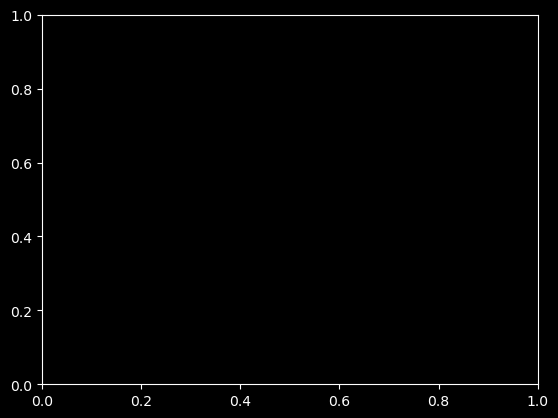

In [132]:
unit=1334	
df1 = df_units[df_units.probe=='C'][df_units.KSlabel=='good']
f,ax=plt.subplots(1,1)
psth.psth_line(times=df1[df1.index==unit].times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
              ymax=60,binsize=0.05,pre=2.0,axes=ax,color='#487697')

psth.psth_line(times=df1[df1.index==unit].times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') ].start_time.values,
              ymax=60,binsize=0.05,pre=2.0,axes=ax,color='#ffaa00')
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps')
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.png')

f,ax=plt.subplots(2,1)
psth.raster(times=df1[df1.index==unit].times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
              axes=ax[0],color='#487697',timeDomain=True,post=3,ms=8)
psth.raster(times=df1[df1.index==unit].times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') ].start_time.values,
              axes=ax[1],color='#ffaa00',timeDomain=True,post=3,ms=8)
for ax_ in ax: ax_.set_xlim(-0.5,1.0)
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')

### Plot bassed on manually curated PHY units

In [ ]:
unit=1
df1 = df_units[df_units.probe=='A'][df_units.label==2]
f,ax=plt.subplots(1,1)
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_detected_baseline') & (df_stim.optogenetics_LED_state == 0)].start_time.values[1::2],
              ymax=60,binsize=0.05,axes=ax,color='#487697')
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_detected_perturbation') ].start_time.values[1::2],
              ymax=60,binsize=0.05,axes=ax,color='#ffaa00')
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps')
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.png')

f,ax=plt.subplots(2,1)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_detected_baseline') & (df_stim.optogenetics_LED_state == 0)].start_time.values[1::2],
              axes=ax[0],color='#487697',timeDomain=True,post=1.5,ms=8)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='pellet_detected_perturbation') ].start_time.values[1::2],
              axes=ax[1],color='#ffaa00',timeDomain=True,post=1.5,ms=8)
for ax_ in ax: ax_.set_xlim(-0.5,1.0)
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')

In [ ]:
# Print version information
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("h5py version:", h5py.__version__)
print("pynwb version:", pynwb.__version__)
# print("dlab version:", dlab.__version__)
# print("tqdm version:", tqdm.__version__)
print("open_ephys version:", Session.__module__)  # If open_ephys is not installed, this will raise an error
print("hdmf version:", H5DataIO.__module__)  # If hdmf is not installed, this will raise an error
# print("nwbwidgets version:", nwbwidgets.__version__)